In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

--2025-11-22 16:23:53--  https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4767 (4.7K) [application/x-sh]
Saving to: ‘/tmp/firedrake-install.sh’

/tmp/firedrake-inst 100%[===================>]   4.66K  --.-KB/s    in 0s      

2025-11-22 16:23:53 (62.2 MB/s) - ‘/tmp/firedrake-install.sh’ saved [4767/4767]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FIREDRAKE_INSTALLED=/usr/local/share/fem-on-colab/firedrake.installed
+ [[ ! -f /usr/local/share/fem-on-colab/firedrake.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/1f62

In [3]:
import firedrake as fd
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec
import os.path
from ufl import tanh as ufl_tanh
#import os ONNO 11-02-2023: no idea about opnumthreats warning?
os.environ["OMP_NUM_THREADS"] = "4"

/usr/local/lib/python3.12/dist-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Prior to start time loop. Hallo!
time counter and time:  1 0.638550856814101


/usr/local/lib/python3.12/dist-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


time counter and time:  1762 1125.126609706418
time counter and time:  3524 2250.2532194129735
time counter and time:  5286 3375.379829119529
time counter and time:  7048 4500.506438825796
time counter and time:  8810 5625.63304853155
time counter and time:  10571 6750.121107380491
time counter and time:  12333 7875.247717086245
time counter and time:  14095 9000.37432679315
time counter and time:  15857 10125.500936500506
time counter and time:  17619 11250.627546207863
time counter and time:  19380 12375.115605058405
time counter and time:  21142 13500.242214765762
time counter and time:  22904 14625.368824473118
time counter and time:  24666 15750.495434180475
time counter and time:  26428 16875.622043886433
time counter and time:  28189 18000.11010273377
time counter and time:  28189 18000.11010273377
Elapsed time (min): 3.283959976832072

*** SHOCK ANALYSIS ***
Total shock tracking points: 17
Average Shock Speed (m/s): -0.002


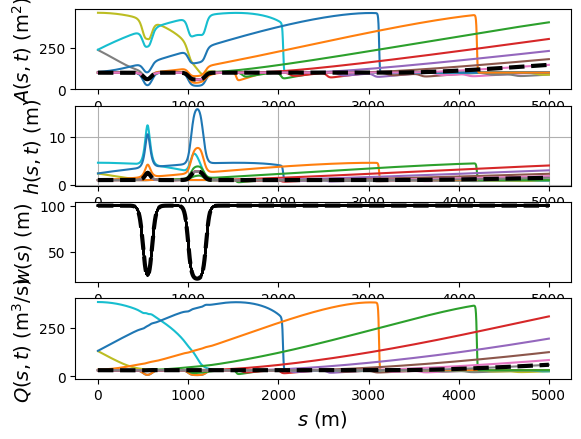

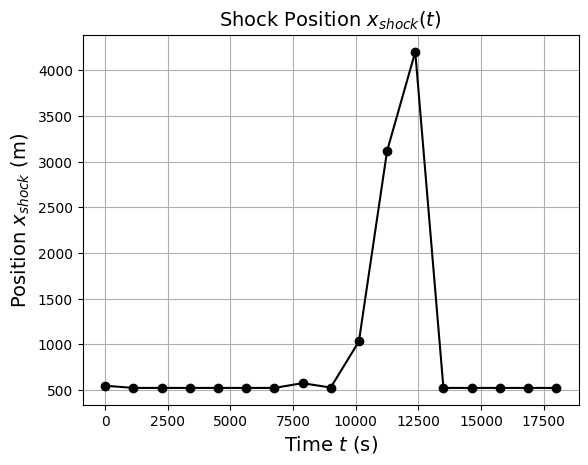

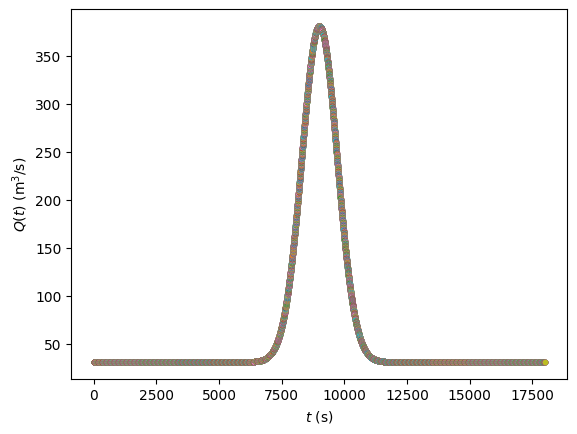

*************** PROGRAM ENDS ******************


In [18]:
# Width functions
#
def find_shock_position(A_vals, w_vals, x_vals):
    """
    Identifies the shock front by locating the point of maximum spatial gradient
    in water depth h = A/w.
    """
    # 1. Calculate Water Depth h = A/w
    h_vals = A_vals / w_vals

    # 2. Calculate the Numerical Gradient (dh/dx)
    # np.gradient calculates the derivative using central difference
    dhdx_vals = np.gradient(h_vals, x_vals)

    # 3. Locate the Maximum Gradient (Shock Position)
    # Find the index where the magnitude of the gradient is maximized.
    shock_index = np.argmax(np.abs(dhdx_vals))

    # Return the position (x-coordinate) of that maximum index
    return x_vals[shock_index]
def width(w0, w1, sa, sb, kk1, ss):
 return w0-0.5*w1*(tanh(kk1*(ss-sa))*tanh(kk1*(sb-ss)))
#
def width2ufl(w0, w1, w2, sa, sb, kk1, kk2, sc, sd, ss):
 return w0-0.25*w1*(1+ufl_tanh(kk1*(ss-sa)))*(1+ufl_tanh(kk1*(sb-ss)))-0.25*w2*(1+ufl_tanh(kk2*(ss-sc)))*(1+ufl_tanh(kk2*(sd-ss)))
 # return w0-0.5*w1*(ufl_tanh(kk1*(ss-sa))*ufl_tanh(kk1*(sb-ss)))-0.5*w2*(ufl_tanh(kk2*(ss-sc))*ufl_tanh(kk2*(sd-ss)))

#
# Parameters
#
Nbc = 4
if Nbc==4:
    Tend = 3600*5 # UPDATE: set this one
    CFL = 0.5*1.0
    Lx = 5000 # UPDATE: vary this one; 5000 may be a bit large bit do a visual converge analysis
    grav = 9.81
    xo = 1000
    xa = 1500-xo
    xb = 1600-xo
    xc = 2000-xo
    xd = 2200-xo
    k1 = 0.024
    k2 = 0.027
    w0 = 100
    w1 = 90
    w2 = 80
    wb = 20
    hb = 4
    nRP = 0 # UPDATE 0: A=w0*h ; 1: Test-Case-2: A<hb*wb A= h*wb ; A>hb*wb: A= A0+Ab=hb*wb+w0*(h-hb) so h-hb=(A-hb*wb)/w0;
    # R = A/(wb+2*hb+(w0-wb)+2*(h-hb)) = A/(wb+2*hb+(w0-wb)+2*(A-hb*wb)/w0)
    #  A<hb*wb then P = wb+2*A/wb ; A>hb*wb then P=(wb+2*hb+(w0-wb)+2*(A-hb*wb)/w0)
    H0 = 1
    slope = -0.001
    sqrtmslope = np.sqrt(-slope)
    Cm = 0.1
    Nx = 1250
    dxx = Lx/Nx
    c00 = np.sqrt(grav*H0)
    dt = CFL*dxx/np.amax(c00) # This should be CFL*dxx/lambdamax
    nmea = 16
    tmease = 0.0
    dtmeas = Tend/nmea
    Qmax = 350  # UPDATE TC0) 0 constant influx TC1/TC2) nonzero varying influx
    tmax = 0.5*Tend
    gamfac = 0.000001
    gamma = 1.0e-5   # s^-2 (as you asked)

nnm = 0  # counter outputs

#
# Mesh
# mesh1d = UnitIntervalMesh(Nx)
mesh1d = fd.IntervalMesh(Nx,Lx)
# 2D mesh: mesh = ExtrudedMesh(mesh1d, layers=Ny)
mesh = mesh1d
#  coords = mesh.coordinates
# 2D mesh and coordinates: coords.dat.data[:,0] = Lx*coords.dat.data[:,0] coords.dat.data = Lx*coords.dat.data
x, = fd.SpatialCoordinate(mesh)

#
# Define function spaces
#
nDG = 0
nCG = 4
DG0 = fd.FunctionSpace(mesh, "DG", nDG) # Finite volume
CG1 = fd.FunctionSpace(mesh, "CG", nCG) # Continuous
A0 = fd.Function(DG0, name="A0") # Previous time step A^n
A01 = fd.Function(DG0, name="A01")
A02 = fd.Function(DG0, name="A02")
FA00 = fd.Function(DG0, name="FA00")
wid0 = fd.Function(CG1, name="wid0")
A1 = fd.Function(DG0, name="A1") # Future time step A^n+1
wid1 = fd.Function(DG0, name="wid1")
A0_trial = fd.TrialFunction(DG0) # Trial/test function; for DG0 unity in cell and zero elsewhere
wid0_trial = fd.TrialFunction(DG0)
A0_test = fd.TestFunction(DG0) # Trial/test function; for DG0 unity in cell and zero elsewhere
wid0_test = fd.TestFunction(DG0)

#
# We define n to be the built-in FacetNormal object;
# a unit normal vector that can be used in integrals over exterior and interior facets.
# We next define un to be an object which is equal to
# if this is positive, and zero if this is negative. This will be useful in the upwind terms.
# how to distinguish interior from exterior facets?
#

# initial condtion and plot it
tijd = 0.0
if Nbc==4: # flow
 wx = width2ufl(w0, w1, w2, xa, xb, k1, k2, xc, xd, x)
 A0 = fd.Function(DG0).interpolate(H0*wx+0.0*x)
 wid0 = fd.Function(CG1).interpolate(wx+0.0*x)

t = tijd
t_ = fd.Constant(t)
smallfac = 10.0**(-10.0)

nx = Nx
xsmall = 0.0*10**(-6)
xvals = np.linspace(0.0+xsmall, Lx-xsmall, nx)
widvals = 0.0*xvals
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4)
tsize = 14
# ax1.set_title(r'$t=0,2,4,5,5.5,6,6.5,8.5,9.5$',fontsize=tsize) ax1.set_ylabel(r'$h(s,t)=h(A(s,t)),s)$ (m)',fontsize=tsize)
ax0.set_ylabel(r'$A(s,t)$ (m$^2$)', fontsize=tsize)
ax1.set_ylabel(r'$h(s,t)$ (m)',fontsize=tsize)
ax1.grid()
ax2.set_ylabel(r'$w(s)$ (m) ',fontsize=tsize)
ax3.set_xlabel(r'$s$ (m) ',fontsize=tsize)
ax3.set_ylabel(r'$Q(s,t)$ (m$^3$/s) ',fontsize=tsize)
#
eta12 = np.array([A0.at(x) for x in xvals]) #
phi12 = np.array([wid0.at(x) for x in xvals])
widL = width2ufl(w0, w1, w2, xa, xb, k1, k2, xc, xd, x)
FA00 = fd.Function(DG0).interpolate( sqrtmslope*A0**(5/3)/(widL+2.0*A0/widL)**(2/3)/Cm ) #
Q12 = np.array([FA00.at(x) for x in xvals]) #
ax1.plot(xvals,eta12/phi12) #
ax2.plot(xvals,phi12) #
ax3.plot(xvals,Q12) #
fig.savefig("sweDG0FV.png")
#
#
#
A00left = fd.Constant(H0*w0)
a_massA0 = A0_test*A0_trial*fd.dx # mass matrix for A0
widL = width2ufl(w0, w1, w2, xa, xb, k1, k2, xc, xd, x)
A0avg = 0.5*(A0('+') + A0('-'))
n = fd.FacetNormal(mesh) # ; odd normals in 1d one at first face is likely wrong # 1D: n = fd.as_vector([1.0])
#
if nRP==0:
 #
 A0left = fd.Constant(H0*w0) # constant inflow for test case
 A0left0 = H0*w0
 #
elif nRP==1:
 #
 A0left = fd.Constant(H0*wb) # constant inflow for test case
 A0left0 = H0*wb
 #
FA0left = fd.Constant(0.0)
widL0 = width2ufl(w0, w1, w2, xa, xb, k1, k2, xc, xd, 0)

if nRP==0:
 #
 FA0 = sqrtmslope*A0**(5/3)/(widL+2.0*A0/widL)**(2/3)/Cm #
 FA0left.assign( sqrtmslope*A0left0**(5/3)/(widL0+2.0*A0left0/widL0)**(2/3)/Cm ) #
 FA0left0 = sqrtmslope*A0left0**(5/3)/(widL0+2.0*A0left0/widL0)**(2/3)/Cm
 FA0fluxmin = sqrtmslope*A0('-')**(5/3)/(widL+2.0*A0('-')/widL)**(2/3)/Cm #
 FA0fluxplu = sqrtmslope*A0('+')**(5/3)/(widL+2.0*A0('+')/widL)**(2/3)/Cm #
 dFA0dA0 = (1/3)*sqrtmslope*A0avg**(2/3)*( 5*widL+6*A0avg/widL )/(widL+2.0*A0avg/widL)**(5/3)/Cm #
 dFA0dA0bnd = (1/3)*sqrtmslope*A0**(2/3)*( 5*widL+6*A0/widL )/(widL+2.0*A0/widL)**(5/3)/Cm
 #
elif nRP==1:
 #
 FA0 = fd.conditional( A0<wb*hb, sqrtmslope*A0**(5/3)/(wb+2.0*A0/wb)**(2/3)/Cm , \
                      sqrtmslope*A0**(5/3)/(wb+2*hb+widL-wb+2.0*(A0-hb*wb)/widL)**(2/3)/Cm )
 #FA0left.assign( fd.conditional( A0left0<hb*wb, sqrtmslope*A0left0**(5/3)/(wb+2.0*A0left0/wb)**(2/3)/Cm , sqrtmslope*A0left0**(5/3)/(wb+2*hb+widL0-wb+2.0*(A0left0-hb*wb)/widL0)**(2/3)/Cm  ) )
 if A0left0<hb*wb:
  FA0left0 = sqrtmslope*A0left0**(5/3)/(wb+2.0*A0left0/wb)**(2/3)/Cm
  Qbase = float(FA0left0)

 else:
  FA0left0 = sqrtmslope*A0left0**(5/3)/(wb+2*hb+widL0-wb+2.0*(A0left0-hb*wb)/widL0)**(2/3)/Cm
  Qbase = float(FA0left0)


 FA0left.assign( FA0left0 )

 Peromi = fd.conditional( A0('-')<(hb*wb+0*A0('-')), wb+2*A0('-')/wb, wb+2*hb+widL-wb+2*(A0('-')-hb*wb)/widL )
 Peripl = fd.conditional( A0('+')<(hb*wb+0*A0('+')), wb+2*A0('+')/wb, wb+2*hb+widL-wb+2*(A0('+')-hb*wb)/widL )
 FA0fluxmin = sqrtmslope*A0('-')**(5/3)/Peromi**(2/3)/Cm #
 FA0fluxplu = sqrtmslope*A0('+')**(5/3)/Peripl**(2/3)/Cm #
 dFA0dA0 = (sqrtmslope/(3*Cm))*A0avg**(2/3)*fd.conditional(A0avg<hb*wb+0*A0avg, (5*wb+6*A0avg/wb)/(wb+2.0*A0avg/wb)**(5/3) , \
                                                             (5*(wb+2*hb+widL-wb-2*hb*wb/widL)+6*A0avg/widL)/(wb+2*hb+widL-wb+2*(A0avg-hb*wb)/widL)**(5/3) ) #
 dFA0dA0bnd = (sqrtmslope/(3*Cm))*A0**(2/3)*fd.conditional(A0<hb*wb+0*A0, (5*wb+6*A0/wb)/(wb+2.0*A0/wb)**(5/3) , \
                                                             (5*(wb+2*hb+widL-wb-2*hb*wb/widL)+6*A0/widL)/(wb+2*hb+widL-wb+2*(A0-hb*wb)/widL)**(5/3) ) #
 #
# Upwind flux
FA0flux = fd.conditional(dFA0dA0*n[0]('+')>0,FA0fluxplu,FA0fluxmin) # 2D FA0flux = fd.conditional(fd.dot(dFA0dA0,n)>0,FA0fluxplu,FA0fluxmin)
FA0fluxbcl =  fd.conditional((dFA0dA0bnd*n[0])>0,FA0left+0.0*A0,FA0left+0.0*A0)#
FA0fluxbcr =  fd.conditional((dFA0dA0bnd*n[0])>0,FA0,FA0)
# RHS rewritten version with test function of: A^n - dt*(F_k+1/12-F_k-1/2))
A0rhs = A0_test*A0*fd.dx - dt*FA0flux*n[0]('+')*(A0_test('+')-A0_test('-'))*fd.dS # derivative of test function zero for DG0
# Boundary terms if cell near boundary ds(1) or ds(2)
A0rhs = A0rhs - dt*FA0fluxbcl*n[0]*A0_test*fd.ds(1) - dt*FA0fluxbcr*n[0]*A0_test*fd.ds(2) #
A0_problem = fd.LinearVariationalProblem(a_massA0, A0rhs, A1)
#
# Next 4 lines not used
#
A0rhs2 = fd.replace(A0rhs, {A0: A01})
A0rhs3 = fd.replace(A0rhs, {A0: A02})
A01_problem = fd.LinearVariationalProblem(a_massA0, A0rhs2, A1)
A02_problem = fd.LinearVariationalProblem(a_massA0, A0rhs3, A1)

#
params= {"ksp_type": "preonly", "pc_type": "jacobi"}
solv1 = fd.LinearVariationalSolver(A0_problem) # , solver_parameters) # =params)
solv11 = fd.LinearVariationalSolver(A01_problem) # , solver_parameters) # =params)
solv12 = fd.LinearVariationalSolver(A02_problem) # , solver_parameters) # =params)

dt0 = dt
dt = 0.0
t_.assign(t)
solv1.solve()
dt = dt0
# --- SHOCK TRACKING INITIALIZATION ---
shock_times = []
shock_positions = []
Qs=[]
print('Prior to start time loop. Hallo!')
nt = 0
tic = time.time()
while t <= Tend:
    t += dt
    nt = nt+1

    t_.assign(t)
    # Variable time step:
    # dFdmax = fd.maximum( (1/3)*sqrtmslope*A0**(2/3)*( 5*widL+6*A0avg/widL )/(widL+2.0*A0/widL)**(5/3)/Cm )
    # dt = CFL*dxx/dFmax
    #
    # Assign inflow:
    Q00 = FA0left0 + Qmax*np.exp(-gamfac*(t-tmax)**2)
   # Qpulse = Qmax * np.exp(-gamma*(t - tmax)**2)
    #Q00 = Qbase + Qpulse
    FA0left.assign(Q00) #

    solv1.solve()
    A0.assign(A1)
    #
    #
    #
    #
    #
    #
    if t>tmease+smallfac:
        # print('t, tmeas:',t, tmease)
        print('time counter and time: ',nt, t)
        tmease = tmease + dtmeas
        nnm = nnm+1
        eta12 = np.array([A0.at(x) for x in xvals]) #
        phi12 = np.array([wid0.at(x) for x in xvals])
        if nRP==0:
          FA00 = fd.Function(DG0).interpolate( sqrtmslope*A0**(5/3)/(widL+2.0*A0/widL)**(2/3)/Cm ) #
        elif nRP==1:
          FA00 = fd.Function(DG0).interpolate( fd.conditional(A0>hb*wb+0*A0, sqrtmslope*A0**(5/3)/(wb*hb+2.0*A0/wb)**(2/3)/Cm , \
                                sqrtmslope*A0**(5/3)/(wb+2*hb+widL-wb+2.0*(A0-hb*wb)/widL)**(2/3)/Cm  ) )
        Q12 = np.array([FA00.at(x) for x in xvals]) #
        Qs.append(Q12)
        x_shock = find_shock_position(eta12, phi12, xvals)
        shock_times.append(t)
        shock_positions.append(x_shock)
        ax0.plot(xvals, eta12)
        ax1.plot(xvals,eta12/phi12) #
        ax2.plot(xvals,phi12,'-k') #
        ax3.plot(xvals,Q12) #

    #if t>tmE+smallfac:
    plt.figure(2)
    plt.plot(t,Q00,'.')

# Plot Last profile
print('time counter and time: ',nt, t)
eta12 = np.array([A0.at(x) for x in xvals]) #
phi12 = np.array([wid0.at(x) for x in xvals])
if nRP==0:
 FA00 = fd.Function(DG0).interpolate( sqrtmslope*A0**(5/3)/(widL+2.0*A0/widL)**(2/3)/Cm ) #
elif nRP==1:
 FA00 = fd.Function(DG0).interpolate( fd.conditional(A0>hb*wb+0*A0, sqrtmslope*A0**(5/3)/(wb*hb+2.0*A0/wb)**(2/3)/Cm , \
                                                     sqrtmslope*A0**(5/3)/(wb+2*hb+widL-wb+2.0*(A0-hb*wb)/widL)**(2/3)/Cm  ) )
Q12 = np.array([FA00.at(x) for x in xvals]) #
ax0.plot(xvals, eta12, '--k', linewidth=3)
ax1.plot(xvals,eta12/phi12,'--k',linewidth=3) #
ax2.plot(xvals,phi12,'--k',linewidth=3) #
ax3.plot(xvals,Q12,'--k',linewidth=3) #

toc = time.time() - tic
print('Elapsed time (min):', toc/60)

# --- SHOCK ANALYSIS & PLOTTING ---
print('\n*** SHOCK ANALYSIS ***')
if len(shock_times) > 1:
    shock_positions_array = np.array(shock_positions)
    shock_times_array = np.array(shock_times)

    # Calculate shock speed (dx/dt) using numerical differentiation
    shock_speed_vals = np.gradient(shock_positions_array, shock_times_array)

    # Find the average speed
    average_shock_speed = np.mean(shock_speed_vals)

    print(f'Total shock tracking points: {len(shock_times)}')
    print(f'Average Shock Speed (m/s): {average_shock_speed:.3f}')

    # Plot Shock Position
    fig_shock = plt.figure(6)
    ax_shock = fig_shock.add_subplot(111)
    ax_shock.plot(shock_times_array, shock_positions_array, 'o-k')
    ax_shock.set_title('Shock Position $x_{shock}(t)$', fontsize=tsize)
    ax_shock.set_xlabel('Time $t$ (s)', fontsize=tsize)
    ax_shock.set_ylabel('Position $x_{shock}$ (m)', fontsize=tsize)
    ax_shock.grid()
    fig_shock.savefig("sweDG0FV_ShockPosition.png")
else:
    print('Not enough data points collected to calculate shock speed.')


fig.savefig("sweDG0FVfin.png")
plt.figure(2)
plt.xlabel('$t$ (s)')
plt.ylabel('$Q(t)$ (m$^3$/s)')
plt.savefig("sweDG0FVEt.png")

plt.show()
print('*************** PROGRAM ENDS ******************')

/usr/local/lib/python3.12/dist-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Prior to start time loop. Hallo!
time counter and time:  1 0.3192754284070505
time counter and time:  3524 1125.1266097064868
time counter and time:  7048 2250.253219412898
time counter and time:  10571 3375.0605536902453
time counter and time:  14095 4500.187163396575
time counter and time:  17619 5625.313773103931
time counter and time:  21142 6750.121107382881
time counter and time:  24666 7875.2477170902375
time counter and time:  28189 9000.055051366886
time counter and time:  31713 10125.181661071038
time counter and time:  35237 11250.30827077519
time counter and time:  38760 12375.115605050934
time counter and time:  42284 13500.242214755086
time counter and time:  45807 14625.049549030831
time counter and time:  49331 15750.176158734983
time counter and time:  52855 16875.302768439135
time counter and time:  56378 18000.11010271488
time counter and time:  56378 18000.11010271488
Elapsed time (min): 9.094363049666088


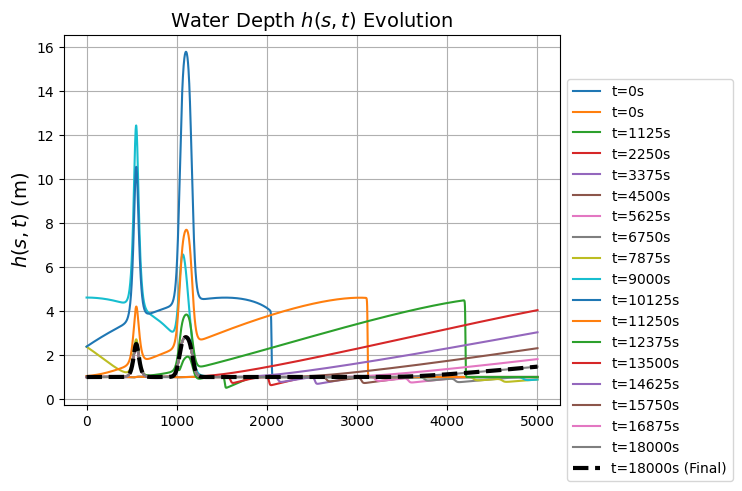

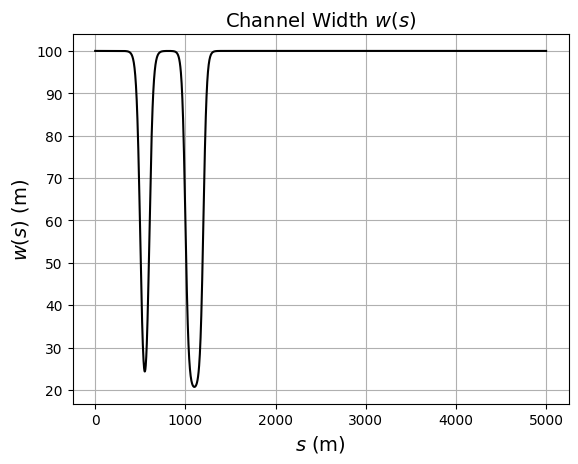

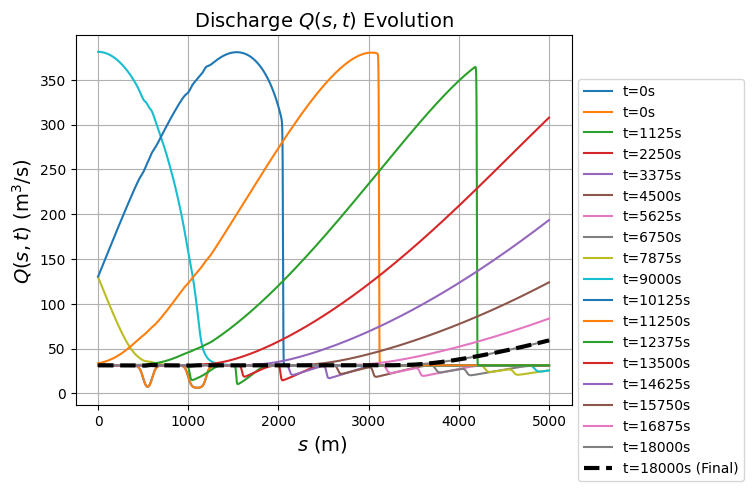

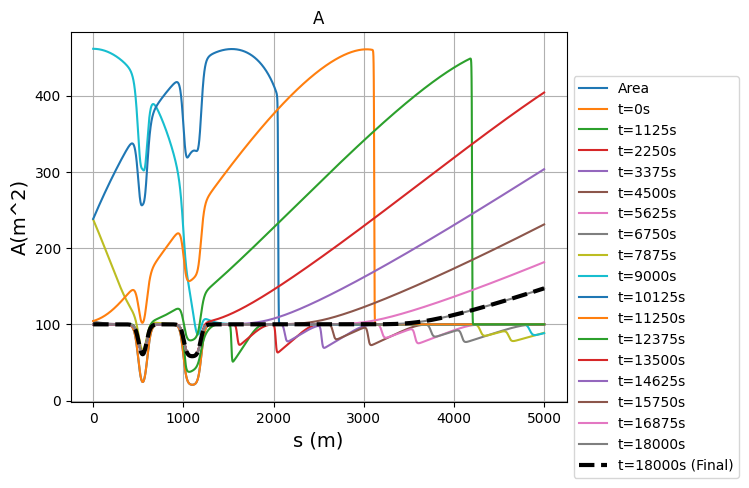

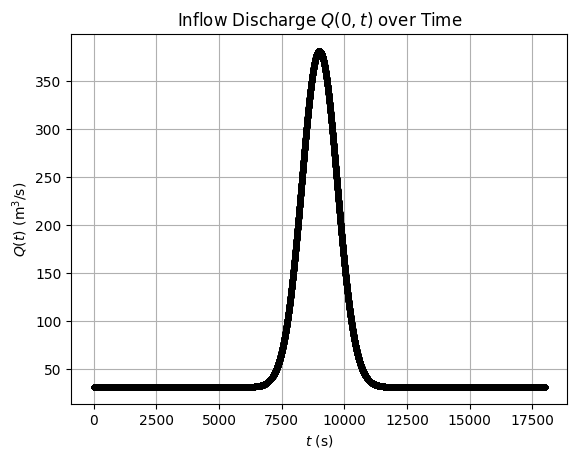

*************** PROGRAM ENDS ******************


In [95]:
#
#
# 1D St-Venant kinematic river flow
# O. Bokhove 02-10-2025
#
# See also: https://www.firedrakeproject.org/demos/DG_advection.py.html which one can (try to) adapt
#
# NOTE: Check TC0 and TC1
#
# TC2: to test and implement
#
#
# from firedrake import *
import firedrake as fd
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec
import os.path
from ufl import tanh as ufl_tanh
import numpy as np
#import os ONNO 11-02-2023: no idea about opnumthreats warning?
os.environ["OMP_NUM_THREADS"] = "1"

def width2_np(scalar_s):
    """Numerical version of width2ufl for postprocessing (uses np.tanh).
    Keeps parameters from the script scope: w0,w1,w2,xa,xb,k1,k2,xc,xd.
    """
    ss = float(scalar_s)
    # Replicate the 0.25*(1+tanh)*(1+tanh) structure from width2ufl
    t1 = np.tanh(k1 * (ss - xa))
    t2 = np.tanh(k1 * (xb - ss))
    t3 = np.tanh(k2 * (ss - xc))
    t4 = np.tanh(k2 * (xd - ss))
    return w0 - 0.25 * w1 * (1.0 + t1) * (1.0 + t2) - 0.25 * w2 * (1.0 + t3) * (1.0 + t4)
def flux_from_A(A_val, s_loc):
    """Compute F(A,s) (or Q) matching your FA0 formula.
    Uses width2_np(s_loc) and the same nRP branching as the model.
    """
    w_loc = width2_np(s_loc)
    A = float(A_val)

    if nRP == 0:
        # Standard channel: P = w + 2*A/w
        P = w_loc + 2.0 * A / w_loc
        F = sqrtmslope * A**(5.0/3.0) / (P**(2.0/3.0)) / Cm
        return F
    else: # nRP == 1 (Compound channel)
        # Conditional perimeter P based on whether A is in the main channel or includes floodplains
        if A < hb * wb:
            # Main channel only: P = wb + 2*A/wb
            P = wb + 2.0 * A / wb
        else:
            # Main channel + floodplain: P = wb + 2*hb + (w_loc - wb) + 2*(A - hb*wb)/w_loc
            P = wb + 2*hb + w_loc - wb + 2.0*(A - hb*wb)/w_loc
        F = sqrtmslope * A**(5.0/3.0) / (P**(2.0/3.0)) / Cm
        return F


def find_shock_position(A_vals, w_vals, x_vals):
    """
    Identifies the shock front by locating the point of maximum spatial gradient
    in water depth h = A/w.
    """
    # 1. Calculate Water Depth h = A/w
    h_vals = A_vals / w_vals

    # 2. Calculate the Numerical Gradient (dh/dx)
    # np.gradient calculates the derivative using central difference
    dhdx_vals = np.gradient(h_vals, x_vals)

    # 3. Locate the Maximum Gradient (Shock Position)
    # Find the index where the magnitude of the gradient is maximized.
    shock_index = np.argmax(np.abs(dhdx_vals))

    # Return the position (x-coordinate) of that maximum index
    return x_vals[shock_index]
# Width functions
#
def width(w0, w1, sa, sb, kk1, ss):
 return w0-0.5*w1*(tanh(kk1*(ss-sa))*tanh(kk1*(sb-ss)))
#
def width2ufl(w0, w1, w2, sa, sb, kk1, kk2, sc, sd, ss):
 return w0-0.25*w1*(1+ufl_tanh(kk1*(ss-sa)))*(1+ufl_tanh(kk1*(sb-ss)))-0.25*w2*(1+ufl_tanh(kk2*(ss-sc)))*(1+ufl_tanh(kk2*(sd-ss)))
 # return w0-0.5*w1*(ufl_tanh(kk1*(ss-sa))*ufl_tanh(kk1*(sb-ss)))-0.5*w2*(ufl_tanh(kk2*(ss-sc))*ufl_tanh(kk2*(sd-ss)))

#
# Parameters
#
Nbc = 4
if Nbc==4:
    Tend = 5*3600 # UPDATE: set this one
    CFL = 0.5
    Lx = 5000 # UPDATE: vary this one; 5000 may be a bit large bit do a visual converge analysis
    grav = 9.81
    xo = 1000
    xa = 1500-xo
    xb = 1600-xo
    xc = 2000-xo
    xd = 2200-xo
    k1 = 0.024
    k2 = 0.027
    w0 = 100
    w1 = 90
    w2 = 80
    wb = 20
    hb = 4
    nRP = 0 # UPDATE 0: A=w0*h ; 1: Test-Case-2: A<hb*wb A= h*wb ; A>hb*wb: A= A0+Ab=hb*wb+w0*(h-hb) so h-hb=(A-hb*wb)/w0;
    # R = A/(wb+2*hb+(w0-wb)+2*(h-hb)) = A/(wb+2*hb+(w0-wb)+2*(A-hb*wb)/w0)
    #  A<hb*wb then P = wb+2*A/wb ; A>hb*wb then P=(wb+2*hb+(w0-wb)+2*(A-hb*wb)/w0)
    H0 = 1
    slope = -0.001
    sqrtmslope = np.sqrt(-slope)
    Cm = 0.1
    Nx = 2500
    dxx = Lx/Nx
    c00 = np.sqrt(grav*H0)
    dt = CFL*dxx/np.amax(c00) # This should be CFL*dxx/lambdamax
    nmea = 16
    tmease = 0.0
    dtmeas = Tend/nmea
    Qmax = 350  # UPDATE TC0) 0 constant influx TC1/TC2) nonzero varying influx
    tmax = 0.5*Tend
    gamfac = 0.000001
    gamma = 1.0e-5   # s^-2 (as you asked)

nnm = 0  # counter outputs

#
# Mesh
# mesh1d = UnitIntervalMesh(Nx)
mesh1d = fd.IntervalMesh(Nx,Lx)
# 2D mesh: mesh = ExtrudedMesh(mesh1d, layers=Ny)
mesh = mesh1d
#  coords = mesh.coordinates
# 2D mesh and coordinates: coords.dat.data[:,0] = Lx*coords.dat.data[:,0] coords.dat.data = Lx*coords.dat.data
x, = fd.SpatialCoordinate(mesh)

#
# Define function spaces
#
nDG = 0
nCG = 4
DG0 = fd.FunctionSpace(mesh, "DG", nDG) # Finite volume
CG1 = fd.FunctionSpace(mesh, "CG", nCG) # Continuous
A0 = fd.Function(DG0, name="A0") # Previous time step A^n
A01 = fd.Function(DG0, name="A01")
A02 = fd.Function(DG0, name="A02")
FA00 = fd.Function(DG0, name="FA00")
wid0 = fd.Function(CG1, name="wid0")
A1 = fd.Function(DG0, name="A1") # Future time step A^n+1
wid1 = fd.Function(DG0, name="wid1")
A0_trial = fd.TrialFunction(DG0) # Trial/test function; for DG0 unity in cell and zero elsewhere
wid0_trial = fd.TrialFunction(DG0)
A0_test = fd.TestFunction(DG0) # Trial/test function; for DG0 unity in cell and zero elsewhere
wid0_test = fd.TestFunction(DG0)

#
# We define n to be the built-in FacetNormal object;
# a unit normal vector that can be used in integrals over exterior and interior facets.
# We next define un to be an object which is equal to
# if this is positive, and zero if this is negative. This will be useful in the upwind terms.
# how to distinguish interior from exterior facets?
#

# initial condtion and plot it
tijd = 0.0
if Nbc==4: # flow
 wx = width2ufl(w0, w1, w2, xa, xb, k1, k2, xc, xd, x)
 A0 = fd.Function(DG0).interpolate(H0*wx+0.0*x)
 wid0 = fd.Function(CG1).interpolate(wx+0.0*x)

t = tijd
t_ = fd.Constant(t)
smallfac = 10.0**(-10.0)
tsize = 14

nx = Nx
xsmall = 0.0*10**(-6)
xvals = np.linspace(0.0+xsmall, Lx-xsmall, nx)
widvals = 0.0*xvals
# --- Setup figures (REVISED) ---
# Figure 1: Water Depth h(s,t)
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(111)
ax1.set_title(r'Water Depth $h(s,t)$ Evolution',fontsize=tsize)
ax1.set_ylabel(r'$h(s,t)$ (m)',fontsize=tsize)
ax1.grid()

# Figure 2: Channel Width w(s)
fig2 = plt.figure(2)
ax2 = fig2.add_subplot(111)
ax2.set_title(r'Channel Width $w(s)$',fontsize=tsize)
ax2.set_ylabel(r'$w(s)$ (m)',fontsize=tsize)
ax2.grid()
ax2.set_xlabel(r'$s$ (m)',fontsize=tsize) # Added x-label here

# Figure 3: Discharge Q(s,t)
fig3 = plt.figure(3)
ax3 = fig3.add_subplot(111)
ax3.set_title(r'Discharge $Q(s,t)$ Evolution',fontsize=tsize)
ax3.set_xlabel(r'$s$ (m) ',fontsize=tsize)
ax3.set_ylabel(r'$Q(s,t)$ (m$^3$/s) ',fontsize=tsize)
ax3.grid()
#

fig5=plt.figure(4)
ax5=fig5.add_subplot(111)
ax5.set_title('A')
ax5.set_xlabel('s (m)',fontsize=tsize)
ax5.set_ylabel('A(m^2)',fontsize=tsize)
ax5.grid()


eta12 = np.array([A0.at(x) for x in xvals]) #
phi12 = np.array([wid0.at(x) for x in xvals])
widL = width2ufl(w0, w1, w2, xa, xb, k1, k2, xc, xd, x)
FA00 = fd.Function(DG0).interpolate( sqrtmslope*A0**(5/3)/(widL+2.0*A0/widL)**(2/3)/Cm ) #
Q12 = np.array([FA00.at(x) for x in xvals]) #
ax1.plot(xvals,eta12/phi12, label=f't=0s') # h = A/w
ax2.plot(xvals,phi12, '-k', label=r'Channel Width $w(s)$') # w
ax3.plot(xvals,Q12, label=f't=0s') # Q
ax5.plot(xvals,eta12, label=f'Area')

fig1.savefig("sweDG0FV_Depth_t0.png")
fig2.savefig("sweDG0FV_Width.png")
fig3.savefig("sweDG0FV_Discharge_t0.png")
#)
#
#
#
A00left = fd.Constant(H0*w0)
a_massA0 = A0_test*A0_trial*fd.dx # mass matrix for A0
widL = width2ufl(w0, w1, w2, xa, xb, k1, k2, xc, xd, x)
A0avg = 0.5*(A0('+') + A0('-'))
n = fd.FacetNormal(mesh) # ; odd normals in 1d one at first face is likely wrong # 1D: n = fd.as_vector([1.0])
#
if nRP==0:
 #
 A0left = fd.Constant(H0*w0) # constant inflow for test case
 A0left0 = H0*w0
 #
elif nRP==1:
 #
 A0left = fd.Constant(H0*wb) # constant inflow for test case
 A0left0 = H0*wb
 #
FA0left = fd.Constant(0.0)
widL0 = width2ufl(w0, w1, w2, xa, xb, k1, k2, xc, xd, 0)

if nRP==0:
 #
 FA0 = sqrtmslope*A0**(5/3)/(widL+2.0*A0/widL)**(2/3)/Cm #
 FA0left.assign( sqrtmslope*A0left0**(5/3)/(widL0+2.0*A0left0/widL0)**(2/3)/Cm ) #
 FA0left0 = sqrtmslope*A0left0**(5/3)/(widL0+2.0*A0left0/widL0)**(2/3)/Cm
 FA0fluxmin = sqrtmslope*A0('-')**(5/3)/(widL+2.0*A0('-')/widL)**(2/3)/Cm #
 FA0fluxplu = sqrtmslope*A0('+')**(5/3)/(widL+2.0*A0('+')/widL)**(2/3)/Cm #
 dFA0dA0 = (1/3)*sqrtmslope*A0avg**(2/3)*( 5*widL+6*A0avg/widL )/(widL+2.0*A0avg/widL)**(5/3)/Cm #
 dFA0dA0bnd = (1/3)*sqrtmslope*A0**(2/3)*( 5*widL+6*A0/widL )/(widL+2.0*A0/widL)**(5/3)/Cm
 #
elif nRP==1:
 #
 FA0 = fd.conditional( A0<wb*hb, sqrtmslope*A0**(5/3)/(wb+2.0*A0/wb)**(2/3)/Cm , \
                      sqrtmslope*A0**(5/3)/(wb+2*hb+widL-wb+2.0*(A0-hb*wb)/widL)**(2/3)/Cm )
 #FA0left.assign( fd.conditional( A0left0<hb*wb, sqrtmslope*A0left0**(5/3)/(wb+2.0*A0left0/wb)**(2/3)/Cm , sqrtmslope*A0left0**(5/3)/(wb+2*hb+widL0-wb+2.0*(A0left0-hb*wb)/widL0)**(2/3)/Cm  ) )
 if A0left0<hb*wb:
  FA0left0 = sqrtmslope*A0left0**(5/3)/(wb+2.0*A0left0/wb)**(2/3)/Cm
  Qbase = float(FA0left0)

 else:
  FA0left0 = sqrtmslope*A0left0**(5/3)/(wb+2*hb+widL0-wb+2.0*(A0left0-hb*wb)/widL0)**(2/3)/Cm
  Qbase = float(FA0left0)


 FA0left.assign( FA0left0 )

 Peromi = fd.conditional( A0('-')<(hb*wb+0*A0('-')), wb+2*A0('-')/wb, wb+2*hb+widL-wb+2*(A0('-')-hb*wb)/widL )
 Peripl = fd.conditional( A0('+')<(hb*wb+0*A0('+')), wb+2*A0('+')/wb, wb+2*hb+widL-wb+2*(A0('+')-hb*wb)/widL )
 FA0fluxmin = sqrtmslope*A0('-')**(5/3)/Peromi**(2/3)/Cm #
 FA0fluxplu = sqrtmslope*A0('+')**(5/3)/Peripl**(2/3)/Cm #
 dFA0dA0 = (sqrtmslope/(3*Cm))*A0avg**(2/3)*fd.conditional(A0avg<hb*wb+0*A0avg, (5*wb+6*A0avg/wb)/(wb+2.0*A0avg/wb)**(5/3) , \
                                                             (5*(wb+2*hb+widL-wb-2*hb*wb/widL)+6*A0avg/widL)/(wb+2*hb+widL-wb+2*(A0avg-hb*wb)/widL)**(5/3) ) #
 dFA0dA0bnd = (sqrtmslope/(3*Cm))*A0**(2/3)*fd.conditional(A0<hb*wb+0*A0, (5*wb+6*A0/wb)/(wb+2.0*A0/wb)**(5/3) , \
                                                             (5*(wb+2*hb+widL-wb-2*hb*wb/widL)+6*A0/widL)/(wb+2*hb+widL-wb+2*(A0-hb*wb)/widL)**(5/3) ) #
 #
# Upwind flux
FA0flux = fd.conditional(dFA0dA0*n[0]('+')>0,FA0fluxplu,FA0fluxmin) # 2D FA0flux = fd.conditional(fd.dot(dFA0dA0,n)>0,FA0fluxplu,FA0fluxmin)
FA0fluxbcl =  fd.conditional((dFA0dA0bnd*n[0])>0,FA0left+0.0*A0,FA0left+0.0*A0)#
FA0fluxbcr =  fd.conditional((dFA0dA0bnd*n[0])>0,FA0,FA0)
# RHS rewritten version with test function of: A^n - dt*(F_k+1/12-F_k-1/2))
A0rhs = A0_test*A0*fd.dx - dt*FA0flux*n[0]('+')*(A0_test('+')-A0_test('-'))*fd.dS # derivative of test function zero for DG0
# Boundary terms if cell near boundary ds(1) or ds(2)
A0rhs = A0rhs - dt*FA0fluxbcl*n[0]*A0_test*fd.ds(1) - dt*FA0fluxbcr*n[0]*A0_test*fd.ds(2) #
A0_problem = fd.LinearVariationalProblem(a_massA0, A0rhs, A1)
#
# Next 4 lines not used
#
A0rhs2 = fd.replace(A0rhs, {A0: A01})
A0rhs3 = fd.replace(A0rhs, {A0: A02})
A01_problem = fd.LinearVariationalProblem(a_massA0, A0rhs2, A1)
A02_problem = fd.LinearVariationalProblem(a_massA0, A0rhs3, A1)

#
params= {"ksp_type": "preonly", "pc_type": "jacobi"}
solv1 = fd.LinearVariationalSolver(A0_problem) # , solver_parameters) # =params)
solv11 = fd.LinearVariationalSolver(A01_problem) # , solver_parameters) # =params)
solv12 = fd.LinearVariationalSolver(A02_problem) # , solver_parameters) # =params)

dt0 = dt
dt = 0.0
t_.assign(t)
solv1.solve()
dt = dt0
# --- SHOCK TRACKING INITIALIZATION (for RH analysis) ---
stored_profiles = [] # stores Area (A) profiles
stored_widths = [] # stores Width (w) profiles (should be constant, but good to store)
stored_times = []  # stores time (t)
stored_shock_positions = [] # stores calculated position s_shock
avg_n = 1 # Number of cells to average for A_L and A_R in RH calculation

print('Prior to start time loop. Hallo!')
nt = 0
tim=[0]
tic = time.time()
lambdas=[]
Qs=[]
As=[]
while t <= Tend:
    t += dt
    nt = nt+1


    t_.assign(t)
    # Variable time step:
    #dFdmax = np.maximum( (1/3)*sqrtmslope*A0**(2/3)*( 5*widL+6*A0avg/widL )/(widL+2.0*A0/widL)**(5/3)/Cm )
    # dt = CFL*dxx/dFmax


    #
    # Assign inflow:
    Q00 = FA0left0 + Qmax*np.exp(-gamfac*(t-tmax)**2)
   # Qpulse = Qmax * np.exp(-gamma*(t - tmax)**2)
    #Q00 = Qbase + Qpulse
    FA0left.assign(Q00) #

    solv1.solve()
    A0.assign(A1)
    #
    #
    #
    #
    #
    #
    if t>tmease+smallfac:
        # print('t, tmeas:',t, tmease)
        print('time counter and time: ',nt, t)
        tmease = tmease + dtmeas
        nnm = nnm+1
        tim.append(t)
        eta12 = np.array([A0.at(x) for x in xvals]) #
        phi12 = np.array([wid0.at(x) for x in xvals])

        stored_times.append(t)

        if nRP==0:
          FA00 = fd.Function(DG0).interpolate( sqrtmslope*A0**(5/3)/(widL+2.0*A0/widL)**(2/3)/Cm ) #
        elif nRP==1:
          FA00 = fd.Function(DG0).interpolate( fd.conditional(A0>hb*wb+0*A0, sqrtmslope*A0**(5/3)/(wb*hb+2.0*A0/wb)**(2/3)/Cm , \
                                sqrtmslope*A0**(5/3)/(wb+2*hb+widL-wb+2.0*(A0-hb*wb)/widL)**(2/3)/Cm  ) )
        Q12 = np.array([FA00.at(x) for x in xvals]) #
        Qs.append(Q12)
        As.append(eta12)

        #ax0.plot(xvals, eta12)
        # Plotting intermediate profiles
        ax1.plot(xvals,eta12/phi12, label=f't={t:.0f}s') # h = A/w
       # ax2.plot(xvals,phi12,'-k') # w is constant in time, only plotted once
        ax3.plot(xvals,Q12, label=f't={t:.0f}s') # Q
        ax5.plot(xvals,eta12, label=f't={t:.0f}s')

   #if t>tmE+smallfac:
    plt.figure(5) # New figure for Inflow Q(t)
    plt.plot(t,Q00,'.k')

# --- Plot Last profile (REVISED) ---
print('time counter and time: ',nt, t)
eta12 = np.array([A0.at(x) for x in xvals]) # A
phi12 = np.array([wid0.at(x) for x in xvals]) # w
if nRP==0:
  FA00 = fd.Function(DG0).interpolate( sqrtmslope*A0**(5/3)/(widL+2.0*A0/widL)**(2/3)/Cm ) #
elif nRP==1:
  FA00 = fd.Function(DG0).interpolate( fd.conditional(A0>hb*wb+0*A0, sqrtmslope*A0**(5/3)/(wb*hb+2.0*A0/wb)**(2/3)/Cm , \
                                     sqrtmslope*A0**(5/3)/(wb+2*hb+widL-wb+2.0*(A0-hb*wb)/widL)**(2/3)/Cm) )
Q12 = np.array([FA00.at(x) for x in xvals]) # Q

# Final profile plots
ax1.plot(xvals,eta12/phi12,'--k',linewidth=3, label=f't={t:.0f}s (Final)') # h
ax3.plot(xvals,Q12,'--k',linewidth=3, label=f't={t:.0f}s (Final)') # Q
ax5.plot(xvals,eta12,'--k',linewidth=3, label=f't={t:.0f}s (Final)')
# Note: w(s) (ax2) is time-independent and only needs one plot.

toc = time.time() - tic
print('Elapsed time (min):', toc/60)


# --- Save and show all figures (REVISED) ---
ax1.legend(bbox_to_anchor=(1, 0.9),fontsize=10)
ax3.legend(bbox_to_anchor=(1, 0.9),fontsize=10)
ax5.legend(bbox_to_anchor=(1, 0.9),fontsize=10)

fig1.savefig("sweDG0FV_Depth_fin.png",format="png",dpi=1000,bbox_inches="tight")
fig3.savefig("sweDG0FV_Discharge_fin.png",dpi=1000,format="png",bbox_inches="tight")
fig5.savefig("sweDG0FV_Area_fin.png",format="png",dpi=1000,bbox_inches="tight")

plt.figure(5)
plt.title('Inflow Discharge $Q(0,t)$ over Time')
plt.xlabel('$t$ (s)')
plt.ylabel('$Q(t)$ (m$^3$/s)')
plt.grid()
plt.savefig("sweDG0FVEt.png")

plt.show()
print('*************** PROGRAM ENDS ******************')

In [19]:
data_dict={"x":xvals,
           "Q":Qs[-1]
}
np.savez("/content/drive/MyDrive/Convergence_data/TC1/QNx1250CFL05", **data_dict)
np.savez("/content/drive/MyDrive/Convergence_data/TC1/ANx1250CFL05", **data_dict)



Prior to start time loop. Hallo!
time counter and time:  63000 12068.611193784856


/usr/local/lib/python3.12/dist-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


time counter and time:  64000 12260.17645082906
time counter and time:  65000 12451.741707873263
time counter and time:  66000 12643.306964917467
time counter and time:  67000 12834.87222196167
time counter and time:  68000 13026.437479005874
time counter and time:  69000 13218.002736050077
time counter and time:  70000 13409.56799309428
time counter and time:  71000 13601.133250138484
time counter and time:  72000 13792.698507182688
time counter and time:  73000 13984.263764226891
time counter and time:  93963 18000.046247659873
Elapsed time (min): 14.509241267045338


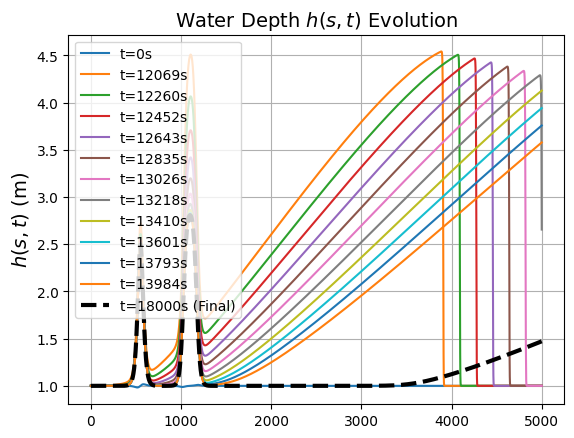

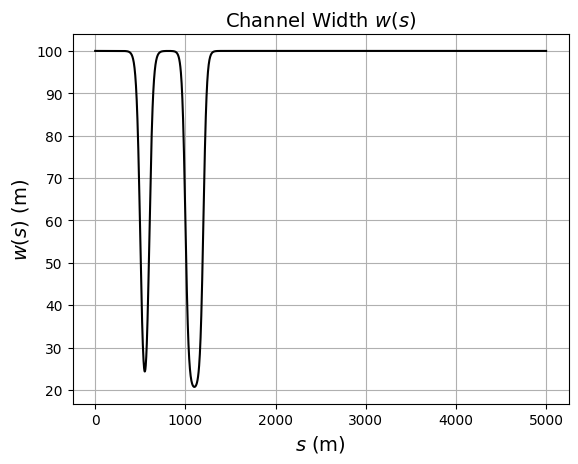

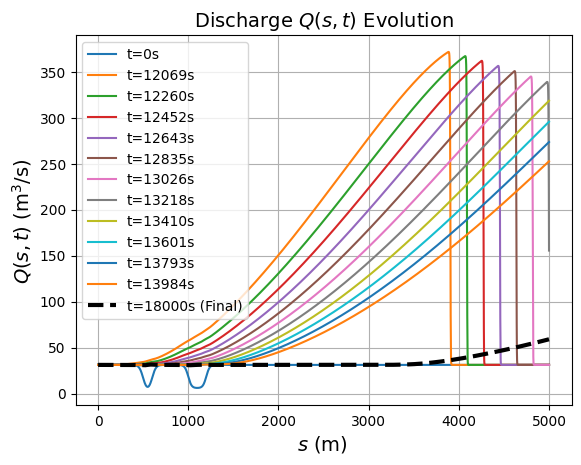

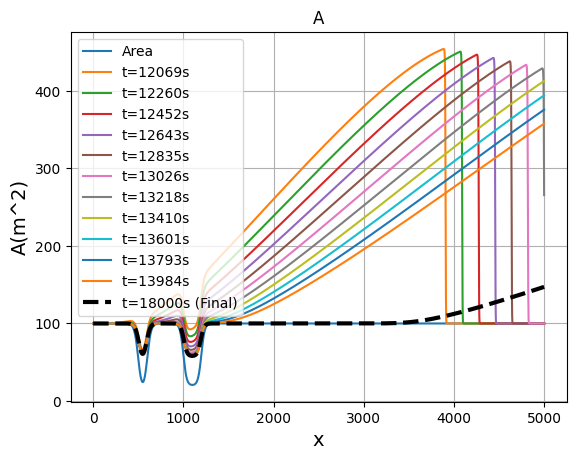

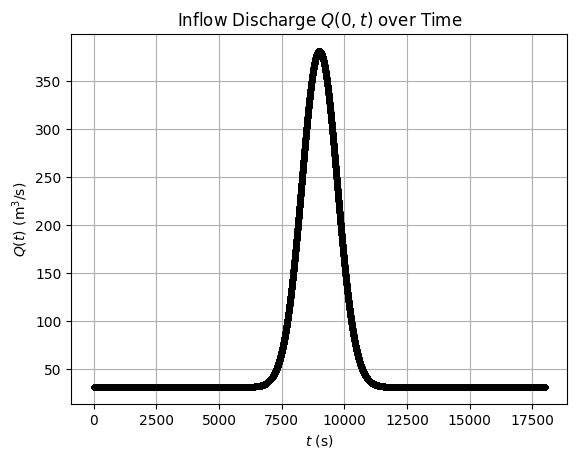

*************** PROGRAM ENDS ******************


In [96]:
#
#
# 1D St-Venant kinematic river flow
# O. Bokhove 02-10-2025
#
# See also: https://www.firedrakeproject.org/demos/DG_advection.py.html which one can (try to) adapt
#
# NOTE: Check TC0 and TC1
#
# TC2: to test and implement
#
#
# from firedrake import *
import firedrake as fd
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec
import os.path
from ufl import tanh as ufl_tanh
import numpy as np
#import os ONNO 11-02-2023: no idea about opnumthreats warning?
os.environ["OMP_NUM_THREADS"] = "1"

def width2_np(scalar_s):
    """Numerical version of width2ufl for postprocessing (uses np.tanh).
    Keeps parameters from the script scope: w0,w1,w2,xa,xb,k1,k2,xc,xd.
    """
    ss = float(scalar_s)
    # Replicate the 0.25*(1+tanh)*(1+tanh) structure from width2ufl
    t1 = np.tanh(k1 * (ss - xa))
    t2 = np.tanh(k1 * (xb - ss))
    t3 = np.tanh(k2 * (ss - xc))
    t4 = np.tanh(k2 * (xd - ss))
    return w0 - 0.25 * w1 * (1.0 + t1) * (1.0 + t2) - 0.25 * w2 * (1.0 + t3) * (1.0 + t4)
def flux_from_A(A_val, s_loc):
    """Compute F(A,s) (or Q) matching your FA0 formula.
    Uses width2_np(s_loc) and the same nRP branching as the model.
    """
    w_loc = width2_np(s_loc)
    A = float(A_val)

    if nRP == 0:
        # Standard channel: P = w + 2*A/w
        P = w_loc + 2.0 * A / w_loc
        F = sqrtmslope * A**(5.0/3.0) / (P**(2.0/3.0)) / Cm
        return F
    else: # nRP == 1 (Compound channel)
        # Conditional perimeter P based on whether A is in the main channel or includes floodplains
        if A < hb * wb:
            # Main channel only: P = wb + 2*A/wb
            P = wb + 2.0 * A / wb
        else:
            # Main channel + floodplain: P = wb + 2*hb + (w_loc - wb) + 2*(A - hb*wb)/w_loc
            P = wb + 2*hb + w_loc - wb + 2.0*(A - hb*wb)/w_loc
        F = sqrtmslope * A**(5.0/3.0) / (P**(2.0/3.0)) / Cm
        return F


def find_shock_position(A_vals, w_vals, x_vals):
    """
    Identifies the shock front by locating the point of maximum spatial gradient
    in water depth h = A/w.
    """
    # 1. Calculate Water Depth h = A/w
    h_vals = A_vals / w_vals

    # 2. Calculate the Numerical Gradient (dh/dx)
    # np.gradient calculates the derivative using central difference
    dhdx_vals = np.gradient(h_vals, x_vals)

    # 3. Locate the Maximum Gradient (Shock Position)
    # Find the index where the magnitude of the gradient is maximized.
    shock_index = np.argmax(np.abs(dhdx_vals))

    # Return the position (x-coordinate) of that maximum index
    return x_vals[shock_index]
# Width functions
#
def width(w0, w1, sa, sb, kk1, ss):
 return w0-0.5*w1*(tanh(kk1*(ss-sa))*tanh(kk1*(sb-ss)))
#
def width2ufl(w0, w1, w2, sa, sb, kk1, kk2, sc, sd, ss):
 return w0-0.25*w1*(1+ufl_tanh(kk1*(ss-sa)))*(1+ufl_tanh(kk1*(sb-ss)))-0.25*w2*(1+ufl_tanh(kk2*(ss-sc)))*(1+ufl_tanh(kk2*(sd-ss)))
 # return w0-0.5*w1*(ufl_tanh(kk1*(ss-sa))*ufl_tanh(kk1*(sb-ss)))-0.5*w2*(ufl_tanh(kk2*(ss-sc))*ufl_tanh(kk2*(sd-ss)))

#
# Parameters
#
Nbc = 4
if Nbc==4:
    Tend = 3600*5 # UPDATE: set this one
    CFL = 0.3
    Lx = 5000 # UPDATE: vary this one; 5000 may be a bit large bit do a visual converge analysis
    grav = 9.81
    xo = 1000
    xa = 1500-xo
    xb = 1600-xo
    xc = 2000-xo
    xd = 2200-xo
    k1 = 0.024
    k2 = 0.027
    w0 = 100
    w1 = 90
    w2 = 80
    wb = 20
    hb = 4
    nRP = 0 # UPDATE 0: A=w0*h ; 1: Test-Case-2: A<hb*wb A= h*wb ; A>hb*wb: A= A0+Ab=hb*wb+w0*(h-hb) so h-hb=(A-hb*wb)/w0;
    # R = A/(wb+2*hb+(w0-wb)+2*(h-hb)) = A/(wb+2*hb+(w0-wb)+2*(A-hb*wb)/w0)
    #  A<hb*wb then P = wb+2*A/wb ; A>hb*wb then P=(wb+2*hb+(w0-wb)+2*(A-hb*wb)/w0)
    H0 = 1
    slope = -0.001
    sqrtmslope = np.sqrt(-slope)
    Cm = 0.1
    Nx = 2500
    dxx = Lx/Nx
    c00 = np.sqrt(grav*H0)
    dt = CFL*dxx/np.amax(c00) # This should be CFL*dxx/lambdamax
    nmea = 16
    tmease = 0.0
    dtmeas = Tend/nmea
    Qmax = 350  # UPDATE TC0) 0 constant influx TC1/TC2) nonzero varying influx
    tmax = 0.5*Tend
    gamfac = 0.000001
    gamma = 1.0e-5   # s^-2 (as you asked)

nnm = 0  # counter outputs

#
# Mesh
# mesh1d = UnitIntervalMesh(Nx)
mesh1d = fd.IntervalMesh(Nx,Lx)
# 2D mesh: mesh = ExtrudedMesh(mesh1d, layers=Ny)
mesh = mesh1d
#  coords = mesh.coordinates
# 2D mesh and coordinates: coords.dat.data[:,0] = Lx*coords.dat.data[:,0] coords.dat.data = Lx*coords.dat.data
x, = fd.SpatialCoordinate(mesh)

#
# Define function spaces
#
nDG = 0
nCG = 4
DG0 = fd.FunctionSpace(mesh, "DG", nDG) # Finite volume
CG1 = fd.FunctionSpace(mesh, "CG", nCG) # Continuous
A0 = fd.Function(DG0, name="A0") # Previous time step A^n
A01 = fd.Function(DG0, name="A01")
A02 = fd.Function(DG0, name="A02")
FA00 = fd.Function(DG0, name="FA00")
wid0 = fd.Function(CG1, name="wid0")
A1 = fd.Function(DG0, name="A1") # Future time step A^n+1
wid1 = fd.Function(DG0, name="wid1")
A0_trial = fd.TrialFunction(DG0) # Trial/test function; for DG0 unity in cell and zero elsewhere
wid0_trial = fd.TrialFunction(DG0)
A0_test = fd.TestFunction(DG0) # Trial/test function; for DG0 unity in cell and zero elsewhere
wid0_test = fd.TestFunction(DG0)

#
# We define n to be the built-in FacetNormal object;
# a unit normal vector that can be used in integrals over exterior and interior facets.
# We next define un to be an object which is equal to
# if this is positive, and zero if this is negative. This will be useful in the upwind terms.
# how to distinguish interior from exterior facets?
#

# initial condtion and plot it
tijd = 0.0
if Nbc==4: # flow
 wx = width2ufl(w0, w1, w2, xa, xb, k1, k2, xc, xd, x)
 A0 = fd.Function(DG0).interpolate(H0*wx+0.0*x)
 wid0 = fd.Function(CG1).interpolate(wx+0.0*x)

t = tijd
t_ = fd.Constant(t)
smallfac = 10.0**(-10.0)
tsize = 14

nx = Nx
xsmall = 0.0*10**(-6)
xvals = np.linspace(0.0+xsmall, Lx-xsmall, nx)
widvals = 0.0*xvals
# --- Setup figures (REVISED) ---
# Figure 1: Water Depth h(s,t)
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(111)
ax1.set_title(r'Water Depth $h(s,t)$ Evolution',fontsize=tsize)
ax1.set_ylabel(r'$h(s,t)$ (m)',fontsize=tsize)
ax1.grid()

# Figure 2: Channel Width w(s)
fig2 = plt.figure(2)
ax2 = fig2.add_subplot(111)
ax2.set_title(r'Channel Width $w(s)$',fontsize=tsize)
ax2.set_ylabel(r'$w(s)$ (m)',fontsize=tsize)
ax2.grid()
ax2.set_xlabel(r'$s$ (m)',fontsize=tsize) # Added x-label here

# Figure 3: Discharge Q(s,t)
fig3 = plt.figure(3)
ax3 = fig3.add_subplot(111)
ax3.set_title(r'Discharge $Q(s,t)$ Evolution',fontsize=tsize)
ax3.set_xlabel(r'$s$ (m) ',fontsize=tsize)
ax3.set_ylabel(r'$Q(s,t)$ (m$^3$/s) ',fontsize=tsize)
ax3.grid()
#

fig5=plt.figure(4)
ax5=fig5.add_subplot(111)
ax5.set_title('A')
ax5.set_xlabel('x',fontsize=tsize)
ax5.set_ylabel('A(m^2)',fontsize=tsize)
ax5.grid()


eta12 = np.array([A0.at(x) for x in xvals]) #
phi12 = np.array([wid0.at(x) for x in xvals])
widL = width2ufl(w0, w1, w2, xa, xb, k1, k2, xc, xd, x)
FA00 = fd.Function(DG0).interpolate( sqrtmslope*A0**(5/3)/(widL+2.0*A0/widL)**(2/3)/Cm ) #
Q12 = np.array([FA00.at(x) for x in xvals]) #
ax1.plot(xvals,eta12/phi12, label=f't=0s') # h = A/w
ax2.plot(xvals,phi12, '-k', label=r'Channel Width $w(s)$') # w
ax3.plot(xvals,Q12, label=f't=0s') # Q
ax5.plot(xvals,eta12, label=f'Area')

fig1.savefig("sweDG0FV_Depth_t0.png")
fig2.savefig("sweDG0FV_Width.png")
fig3.savefig("sweDG0FV_Discharge_t0.png")
#)
#
#
#
A00left = fd.Constant(H0*w0)
a_massA0 = A0_test*A0_trial*fd.dx # mass matrix for A0
widL = width2ufl(w0, w1, w2, xa, xb, k1, k2, xc, xd, x)
A0avg = 0.5*(A0('+') + A0('-'))
n = fd.FacetNormal(mesh) # ; odd normals in 1d one at first face is likely wrong # 1D: n = fd.as_vector([1.0])
#
if nRP==0:
 #
 A0left = fd.Constant(H0*w0) # constant inflow for test case
 A0left0 = H0*w0
 #
elif nRP==1:
 #
 A0left = fd.Constant(H0*wb) # constant inflow for test case
 A0left0 = H0*wb
 #
FA0left = fd.Constant(0.0)
widL0 = width2ufl(w0, w1, w2, xa, xb, k1, k2, xc, xd, 0)

if nRP==0:
 #
 FA0 = sqrtmslope*A0**(5/3)/(widL+2.0*A0/widL)**(2/3)/Cm #
 FA0left.assign( sqrtmslope*A0left0**(5/3)/(widL0+2.0*A0left0/widL0)**(2/3)/Cm ) #
 FA0left0 = sqrtmslope*A0left0**(5/3)/(widL0+2.0*A0left0/widL0)**(2/3)/Cm
 FA0fluxmin = sqrtmslope*A0('-')**(5/3)/(widL+2.0*A0('-')/widL)**(2/3)/Cm #
 FA0fluxplu = sqrtmslope*A0('+')**(5/3)/(widL+2.0*A0('+')/widL)**(2/3)/Cm #
 dFA0dA0 = (1/3)*sqrtmslope*A0avg**(2/3)*( 5*widL+6*A0avg/widL )/(widL+2.0*A0avg/widL)**(5/3)/Cm #
 dFA0dA0bnd = (1/3)*sqrtmslope*A0**(2/3)*( 5*widL+6*A0/widL )/(widL+2.0*A0/widL)**(5/3)/Cm
 #
elif nRP==1:
 #
 FA0 = fd.conditional( A0<wb*hb, sqrtmslope*A0**(5/3)/(wb+2.0*A0/wb)**(2/3)/Cm , \
                      sqrtmslope*A0**(5/3)/(wb+2*hb+widL-wb+2.0*(A0-hb*wb)/widL)**(2/3)/Cm )
 #FA0left.assign( fd.conditional( A0left0<hb*wb, sqrtmslope*A0left0**(5/3)/(wb+2.0*A0left0/wb)**(2/3)/Cm , sqrtmslope*A0left0**(5/3)/(wb+2*hb+widL0-wb+2.0*(A0left0-hb*wb)/widL0)**(2/3)/Cm  ) )
 if A0left0<hb*wb:
  FA0left0 = sqrtmslope*A0left0**(5/3)/(wb+2.0*A0left0/wb)**(2/3)/Cm
  Qbase = float(FA0left0)

 else:
  FA0left0 = sqrtmslope*A0left0**(5/3)/(wb+2*hb+widL0-wb+2.0*(A0left0-hb*wb)/widL0)**(2/3)/Cm
  Qbase = float(FA0left0)


 FA0left.assign( FA0left0 )

 Peromi = fd.conditional( A0('-')<(hb*wb+0*A0('-')), wb+2*A0('-')/wb, wb+2*hb+widL-wb+2*(A0('-')-hb*wb)/widL )
 Peripl = fd.conditional( A0('+')<(hb*wb+0*A0('+')), wb+2*A0('+')/wb, wb+2*hb+widL-wb+2*(A0('+')-hb*wb)/widL )
 FA0fluxmin = sqrtmslope*A0('-')**(5/3)/Peromi**(2/3)/Cm #
 FA0fluxplu = sqrtmslope*A0('+')**(5/3)/Peripl**(2/3)/Cm #
 dFA0dA0 = (sqrtmslope/(3*Cm))*A0avg**(2/3)*fd.conditional(A0avg<hb*wb+0*A0avg, (5*wb+6*A0avg/wb)/(wb+2.0*A0avg/wb)**(5/3) , \
                                                             (5*(wb+2*hb+widL-wb-2*hb*wb/widL)+6*A0avg/widL)/(wb+2*hb+widL-wb+2*(A0avg-hb*wb)/widL)**(5/3) ) #
 dFA0dA0bnd = (sqrtmslope/(3*Cm))*A0**(2/3)*fd.conditional(A0<hb*wb+0*A0, (5*wb+6*A0/wb)/(wb+2.0*A0/wb)**(5/3) , \
                                                             (5*(wb+2*hb+widL-wb-2*hb*wb/widL)+6*A0/widL)/(wb+2*hb+widL-wb+2*(A0-hb*wb)/widL)**(5/3) ) #
 #
# Upwind flux
FA0flux = fd.conditional(dFA0dA0*n[0]('+')>0,FA0fluxplu,FA0fluxmin) # 2D FA0flux = fd.conditional(fd.dot(dFA0dA0,n)>0,FA0fluxplu,FA0fluxmin)
FA0fluxbcl =  fd.conditional((dFA0dA0bnd*n[0])>0,FA0left+0.0*A0,FA0left+0.0*A0)#
FA0fluxbcr =  fd.conditional((dFA0dA0bnd*n[0])>0,FA0,FA0)
# RHS rewritten version with test function of: A^n - dt*(F_k+1/12-F_k-1/2))
A0rhs = A0_test*A0*fd.dx - dt*FA0flux*n[0]('+')*(A0_test('+')-A0_test('-'))*fd.dS # derivative of test function zero for DG0
# Boundary terms if cell near boundary ds(1) or ds(2)
A0rhs = A0rhs - dt*FA0fluxbcl*n[0]*A0_test*fd.ds(1) - dt*FA0fluxbcr*n[0]*A0_test*fd.ds(2) #
A0_problem = fd.LinearVariationalProblem(a_massA0, A0rhs, A1)
#
# Next 4 lines not used
#
A0rhs2 = fd.replace(A0rhs, {A0: A01})
A0rhs3 = fd.replace(A0rhs, {A0: A02})
A01_problem = fd.LinearVariationalProblem(a_massA0, A0rhs2, A1)
A02_problem = fd.LinearVariationalProblem(a_massA0, A0rhs3, A1)

#
params= {"ksp_type": "preonly", "pc_type": "jacobi"}
solv1 = fd.LinearVariationalSolver(A0_problem) # , solver_parameters) # =params)
solv11 = fd.LinearVariationalSolver(A01_problem) # , solver_parameters) # =params)
solv12 = fd.LinearVariationalSolver(A02_problem) # , solver_parameters) # =params)

dt0 = dt
dt = 0.0
t_.assign(t)
solv1.solve()
dt = dt0
# --- SHOCK TRACKING INITIALIZATION (for RH analysis) ---
stored_profiles = [] # stores Area (A) profiles
stored_widths = [] # stores Width (w) profiles (should be constant, but good to store)
stored_times = []  # stores time (t)
stored_shock_positions = [] # stores calculated position s_shock
avg_n = 1 # Number of cells to average for A_L and A_R in RH calculation

print('Prior to start time loop. Hallo!')
nt = 0
tim=[0]
tic = time.time()
lambdas=[]
Qs=[]
As=[]
while t <= Tend:
    t += dt
    nt = nt+1


    t_.assign(t)
    # Variable time step:
    #dFdmax = np.maximum( (1/3)*sqrtmslope*A0**(2/3)*( 5*widL+6*A0avg/widL )/(widL+2.0*A0/widL)**(5/3)/Cm )
    # dt = CFL*dxx/dFmax


    #
    # Assign inflow:
    Q00 = FA0left0 + Qmax*np.exp(-gamfac*(t-tmax)**2)
   # Qpulse = Qmax * np.exp(-gamma*(t - tmax)**2)
    #Q00 = Qbase + Qpulse
    FA0left.assign(Q00) #

    solv1.solve()
    A0.assign(A1)
    #
    #
    #
    #
    #
    #
    if t > 12000 and t < 14000 and nt % 1000 == 0: #t>tmease+smallfac:
        # print('t, tmeas:',t, tmease)
        print('time counter and time: ',nt, t)
        tmease = tmease + dtmeas
        nnm = nnm+1
        tim.append(t)
        eta12 = np.array([A0.at(x) for x in xvals]) #
        phi12 = np.array([wid0.at(x) for x in xvals])

        stored_times.append(t)

        if nRP==0:
          FA00 = fd.Function(DG0).interpolate( sqrtmslope*A0**(5/3)/(widL+2.0*A0/widL)**(2/3)/Cm ) #
        elif nRP==1:
          FA00 = fd.Function(DG0).interpolate( fd.conditional(A0>hb*wb+0*A0, sqrtmslope*A0**(5/3)/(wb*hb+2.0*A0/wb)**(2/3)/Cm , \
                                sqrtmslope*A0**(5/3)/(wb+2*hb+widL-wb+2.0*(A0-hb*wb)/widL)**(2/3)/Cm  ) )
        Q12 = np.array([FA00.at(x) for x in xvals]) #
        Qs.append(Q12)
        As.append(eta12)

        #ax0.plot(xvals, eta12)
        # Plotting intermediate profiles
        ax1.plot(xvals,eta12/phi12, label=f't={t:.0f}s') # h = A/w
       # ax2.plot(xvals,phi12,'-k') # w is constant in time, only plotted once
        ax3.plot(xvals,Q12, label=f't={t:.0f}s') # Q
        ax5.plot(xvals,eta12, label=f't={t:.0f}s')

   #if t>tmE+smallfac:
    plt.figure(5) # New figure for Inflow Q(t)
    plt.plot(t,Q00,'.k')

# --- Plot Last profile (REVISED) ---
print('time counter and time: ',nt, t)
eta12 = np.array([A0.at(x) for x in xvals]) # A
phi12 = np.array([wid0.at(x) for x in xvals]) # w
if nRP==0:
  FA00 = fd.Function(DG0).interpolate( sqrtmslope*A0**(5/3)/(widL+2.0*A0/widL)**(2/3)/Cm ) #
elif nRP==1:
  FA00 = fd.Function(DG0).interpolate( fd.conditional(A0>hb*wb+0*A0, sqrtmslope*A0**(5/3)/(wb*hb+2.0*A0/wb)**(2/3)/Cm , \
                                     sqrtmslope*A0**(5/3)/(wb+2*hb+widL-wb+2.0*(A0-hb*wb)/widL)**(2/3)/Cm) )
Q12 = np.array([FA00.at(x) for x in xvals]) # Q

# Final profile plots
ax1.plot(xvals,eta12/phi12,'--k',linewidth=3, label=f't={t:.0f}s (Final)') # h
ax3.plot(xvals,Q12,'--k',linewidth=3, label=f't={t:.0f}s (Final)') # Q
ax5.plot(xvals,eta12,'--k',linewidth=3, label=f't={t:.0f}s (Final)')
# Note: w(s) (ax2) is time-independent and only needs one plot.

toc = time.time() - tic
print('Elapsed time (min):', toc/60)


# --- Save and show all figures (REVISED) ---
ax1.legend()
ax3.legend()
ax5.legend()

fig1.savefig("sweDG0FV_Depth_fin.png")
fig3.savefig("sweDG0FV_Discharge_fin.png")

plt.figure(5)
plt.title('Inflow Discharge $Q(0,t)$ over Time')
plt.xlabel('$t$ (s)')
plt.ylabel('$Q(t)$ (m$^3$/s)')
plt.grid()
plt.savefig("sweDG0FVEt.png")

plt.show()
print('*************** PROGRAM ENDS ******************')

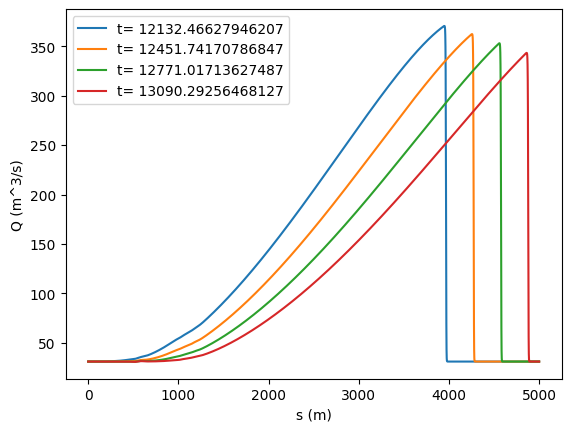

In [ ]:
indices = [0,1,2,3]

plt.figure()
for i in indices:
    plt.plot(xvals, Qs[i], label=f"t= {stored_times[i]}")

plt.xlabel("s (m)")
plt.ylabel(r"Q (m^3/s)")
plt.legend()
#plt.savefig("/content/drive/MyDrive/TCQ.png",format="png",dpi=1000,bbox_inches="tight")
plt.show()

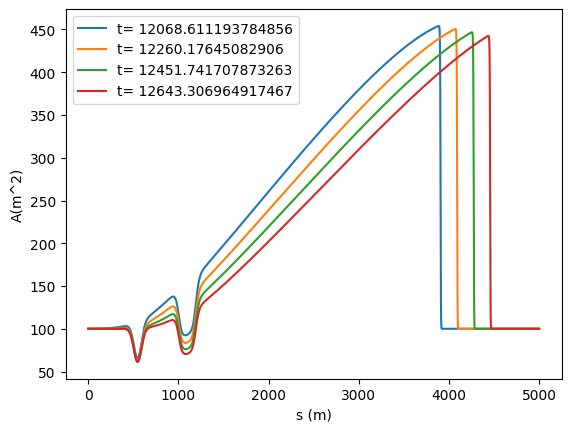

In [97]:
indices = [0,1,2,3]

plt.figure()
for i in indices:
    plt.plot(xvals, As[i], label=f"t= {stored_times[i]}")

plt.xlabel("s (m)")
plt.ylabel(r"A(m^2)")
plt.legend()
plt.savefig("/content/drive/MyDrive/TCA.png",format="png",dpi=1000,bbox_inches="tight")
plt.show()

[np.float64(12132.46627946207), np.float64(12451.74170786847), np.float64(12771.01713627487), np.float64(13090.29256468127)]
[np.float64(0.9588036589835361), np.float64(0.952536968401945), np.float64(0.9462702778203526)]


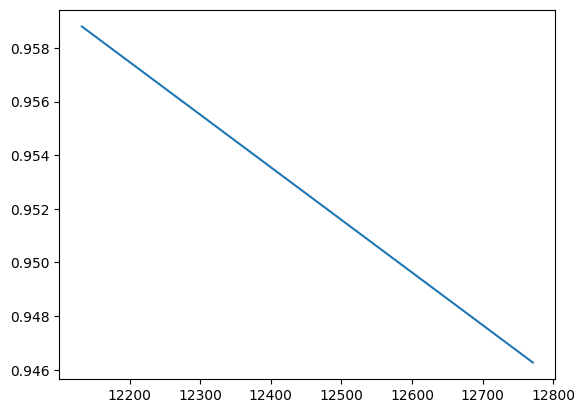

In [ ]:
numerical_speeds=[]
ts=[]
for i in indices:
  ts.append(stored_times[i])
for i in range(len(indices)-1):
  smax= xvals[np.argmax(Qs[i])]
  spmax= xvals[np.argmax([Qs[i+1]])]
  ds = spmax-smax
  dt = stored_times[i+1]-stored_times[i]
  numerical_speeds.append(ds/dt)

print(ts)
plt.plot(ts[:-1],numerical_speeds)
print(numerical_speeds)

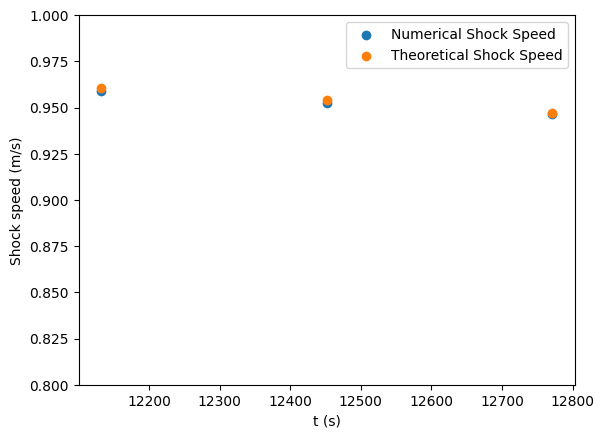

In [ ]:
def Rankine_Stable_Finder(Profile, tolerance=1e-5, min_stable_cells=40):
    """
    Finds the upstream (High State) and downstream (Low State) stable values
    from a profile (Area or Flux) by tracking the max value and stabilization.

    Args:
        Profile (np.array): The Area or Flux profile at a given time (e.g., A6 or Q6).
        tolerance (float): Maximum change between adjacent cells for stability.
        min_stable_cells (int): Number of consecutive stable cells required.

    Returns:
        tuple: (Value_L, Value_R) or (np.nan, np.nan) if states are not found.
    """

    # 1. Find High State (Value_L)
    Value_L = np.max(Profile)
    maxindex = np.argmax(Profile)

    if maxindex >= len(Profile) - 2:
        print("Warning: Max value is near the end. Downstream tracking unreliable.")
        return Value_L, np.nan

    # 2. Track Stabilization Downstream (Find Value_R)
    stable_indices = []

    # Start scanning after the steep transition zone (maxindex + 1)
    search_start_index = maxindex + 1

    for i in range(search_start_index, len(Profile) - 1):

        delta_Profile = np.abs(Profile[i] - Profile[i+1])

        if delta_Profile < tolerance:
            # Add the current index to the stable list
            stable_indices.append(i)

            # Check if enough consecutive stable cells have been found
            if len(stable_indices) >= min_stable_cells:
                # Value_R is the average of the confirmed stable window
                Value_R = np.mean(Profile[i - min_stable_cells + 1 : i + 1])
                return Value_L, Value_R
        else:
            # If the change is significant, reset the counter
            stable_indices = []

    # If the loop finishes without finding a stable plateau
    return Value_L, np.nan

sigmas=[]
ALs=[]
Ars=[]
QLs=[]
QRs=[]
for i in range(len(indices)-1):
  AL, AR =  Rankine_Stable_Finder(As[i])
  QL, QR =  Rankine_Stable_Finder(Qs[i],tolerance=1e-4, min_stable_cells=10)
  ALs.append(AL)
  Ars.append(AR)
  QLs.append(QL)
  QRs.append(QR)
  sigma = (QL - QR) / (AL - AR)
  sigmas.append(sigma)

plt.scatter(ts[:-1],numerical_speeds,label="Numerical Shock Speed")
plt.ylim(0.8,1)
plt.scatter(ts[:-1],sigmas,label="Theoretical Shock Speed")
plt.xlabel("t (s)")
plt.legend()
plt.ylabel("Shock speed (m/s)")
plt.savefig("/content/drive/MyDrive/TCsigma.png",format="png",dpi=1000,bbox_inches="tight")
plt.show()





In [ ]:
print(numerical_speeds)
print(sigmas)

[np.float64(0.9588036589835361), np.float64(0.952536968401945), np.float64(0.9462702778203526)]
[np.float64(0.9604024109159657), np.float64(0.9540553935264284), np.float64(0.946793860082408)]


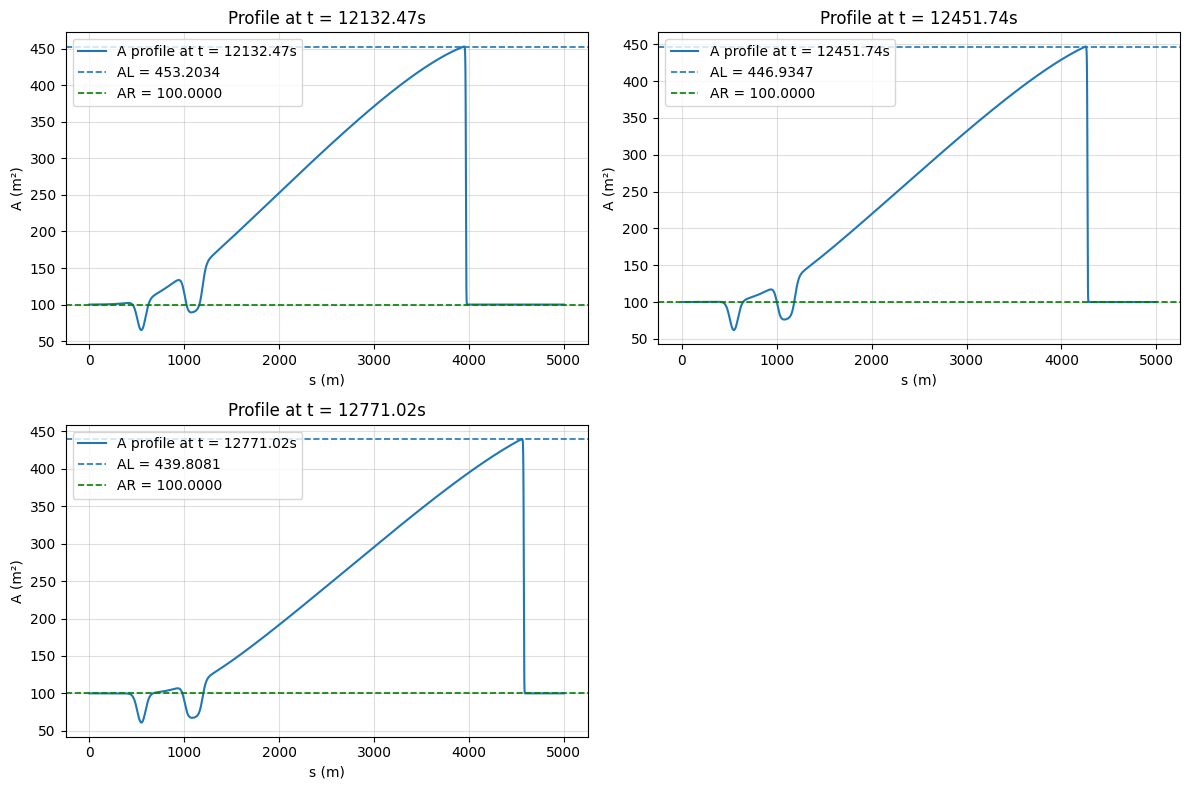

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i in range(3):   # three profiles
    ax = axes[i]

    # Plot Area profile
    ax.plot(xvals, As[i], label=f"A profile at t = {ts[i]:.2f}s")

    # AL line
    ax.axhline(ALs[i], linestyle='--', linewidth=1.2,
               label=f"AL = {ALs[i]:.4f}")

    # AR line
    ax.axhline(Ars[i], linestyle='--', linewidth=1.2,
               label=f"AR = {Ars[i]:.4f}",color="green")

    ax.set_title(f"Profile at t = {ts[i]:.2f}s")
    ax.set_xlabel("s (m)")
    ax.set_ylabel("A (m²)")
    ax.grid(True, alpha=0.4)
    ax.legend()

# Optional: leave the 4th subplot blank or label it
axes[3].axis("off")  # hide unused subplot
# axes[3].text(0.5, 0.5, "Extra panel", ha='center', va='center')

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/AreaSeries.png",format="png",dpi=1000,bbox_inches="tight")
plt.show()



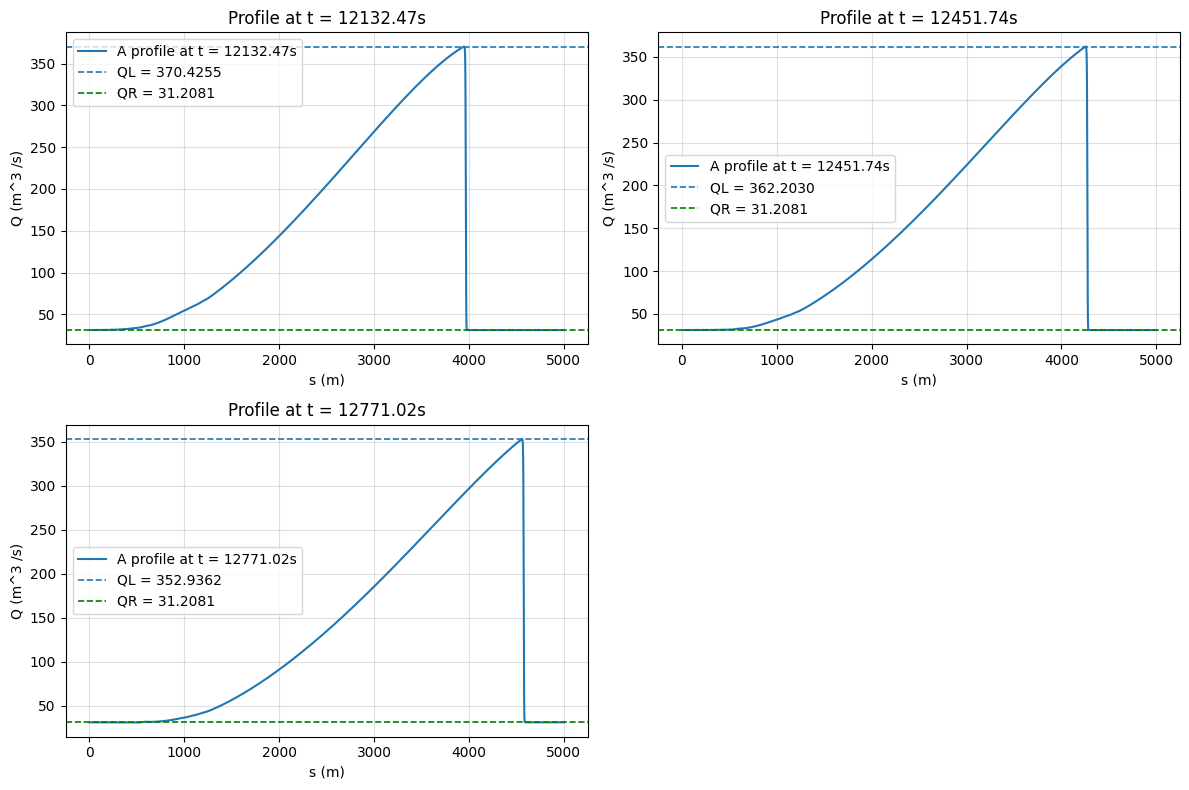

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i in range(3):   # three profiles
    ax = axes[i]

    # Plot Area profile
    ax.plot(xvals, Qs[i], label=f"A profile at t = {ts[i]:.2f}s")

    # AL line
    ax.axhline(QLs[i], linestyle='--', linewidth=1.2,
               label=f"QL = {QLs[i]:.4f}")

    # AR line
    ax.axhline(QRs[i], linestyle='--', linewidth=1.2,
               label=f"QR = {QRs[i]:.4f}",color="green")

    ax.set_title(f"Profile at t = {ts[i]:.2f}s")
    ax.set_xlabel("s (m)")
    ax.set_ylabel("Q (m^3 /s)")
    ax.grid(True, alpha=0.4)
    ax.legend()

# Optional: leave the 4th subplot blank or label it
axes[3].axis("off")  # hide unused subplot
# axes[3].text(0.5, 0.5, "Extra panel", ha='center', va='center')

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/QSeries.png",format="png",dpi=1000,bbox_inches="tight")

plt.show()

In [ ]:
import numpy as np

def Rankine(A, tolerance=1e-4):

    AL = np.max(A)
    maxindex = np.argmax(A)

    if maxindex >= len(A) - 2:
        print("Warning: Max Area is near the end of the array. Downstream tracking is unreliable.")
        return AL, np.nan

    stable_indices = []

    search_start_index = maxindex + 1

    for i in range(search_start_index, len(A) - 1):

        delta_A = np.abs(A[i] - A[i+1])

        if delta_A < tolerance:
            stable_indices.append(i)

            if len(stable_indices) >= 40:
                AR = np.mean(A[i : i + 40])
                return AL, AR
        else:
            stable_indices = []
    AR= stable_indices[-1]
    return AL, stable_indices

np.float64(0.9556745531897486)

In [31]:
Q1250 = np.load("/content/drive/MyDrive/Convergence_data/TC1/ANx1250CFL05.npz")
Q2500 = np.load("/content/drive/MyDrive/Convergence_data/TC1/ANx2500CFL05.npz")
Q5000 = np.load("/content/drive/MyDrive/Convergence_data/TC1/ANx5000CFL05.npz")
Q10000=np.load("/content/drive/MyDrive/Convergence_data/TC1/ANx10000CFL05.npz")

Q1250data = Q1250["Q"]
Q2500data = Q2500["Q"]
Q5000data = Q5000["Q"]
Q10000data = Q10000["Q"]


In [32]:
def stride(Nx,Nx1):
  stride = (Nx - 1) // (Nx1 - 1)

  return stride

highres=Q10000data[::stride(10000,5000)]
highres2= Q10000data[::stride(10000,2500)]
highres3= Q10000data[::stride(10000,1250)]

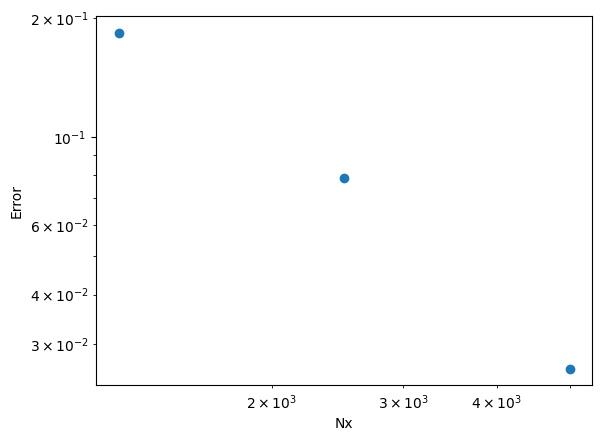

In [52]:
E1 = np.sqrt(np.mean((highres - Q5000data)**2))
E2 = np.sqrt(np.mean((highres2 - Q2500data)**2))
E3 = np.sqrt(np.mean((highres3 - Q1250data)**2))

errors=[E1,E2,E3]
resol=[5000,2500,1250]

plt.scatter(resol,errors)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Nx")
plt.ylabel("Error")
plt.savefig("/content/drive/MyDrive/TC1spatialerror.png",format="png",dpi=1000,bbox_inches="tight")
plt.show()


In [39]:
Q1 = np.load("/content/drive/MyDrive/Convergence_data/TC1/ANx2500CFL1.npz")
Q05 = np.load("/content/drive/MyDrive/Convergence_data/TC1/ANx2500CFL05.npz")
Q025 = np.load("/content/drive/MyDrive/Convergence_data/TC1/ANx2500CFL025.npz")
Q0125=np.load("/content/drive/MyDrive/Convergence_data/TC1/ANx2500CFL0125.npz")

Q1data = Q1["Q"]
Q05data = Q05["Q"]
Q025data = Q025["Q"]
Q0125data = Q0125["Q"]

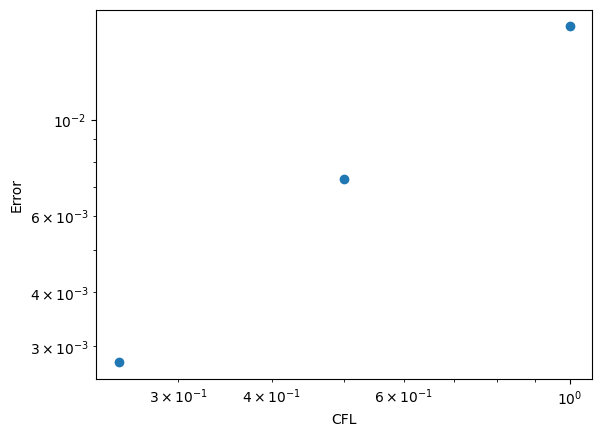

In [53]:
et1= np.sqrt(np.mean((Q0125data - Q1data)**2))
et2= np.sqrt(np.mean((Q0125data - Q05data)**2))
et3= np.sqrt(np.mean((Q0125data - Q025data)**2))


errors=[et1,et2,et3]
cfl=[1,0.5,0.25]

plt.scatter(cfl,errors)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("CFL")
plt.ylabel("Error")
plt.savefig("/content/drive/MyDrive/TC1timeerror.png",format="png",dpi=1000,bbox_inches="tight")

plt.show()

log–log gradient = 1.286025844616048


A0left0,FA0left0 20 5.935193360261284
Prior to start time loop. Hallo!
time counter and time:  38000 12132.46627946207


/usr/local/lib/python3.12/dist-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


time counter and time:  39000 12451.74170786847
time counter and time:  40000 12771.01713627487
time counter and time:  41000 13090.29256468127
time counter and time:  42000 13409.567993087669
time counter and time:  43000 13728.843421494068
time counter and time:  56378 18000.11010271488
Elapsed time (min): 9.15532155831655


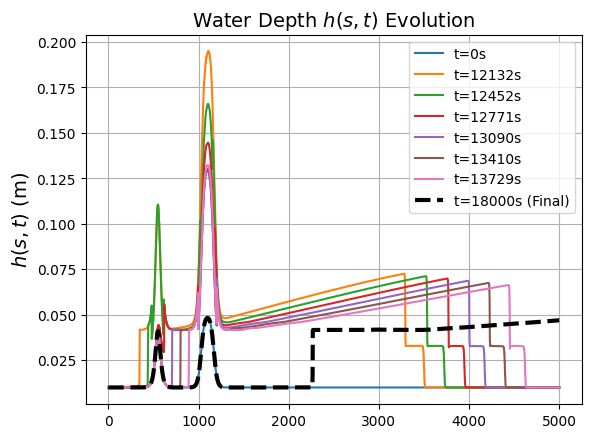

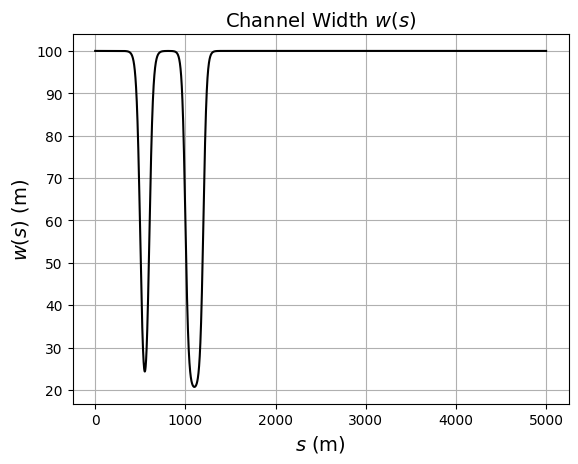

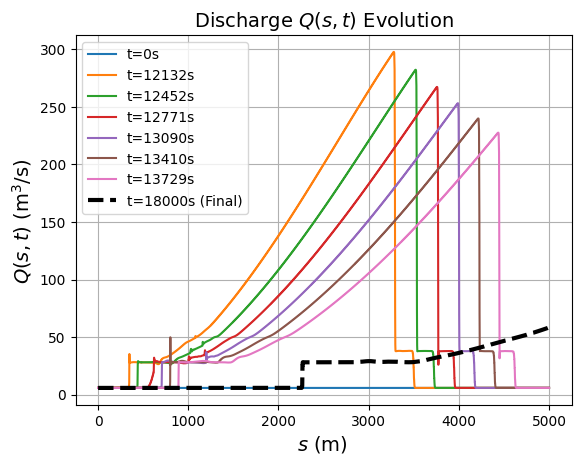

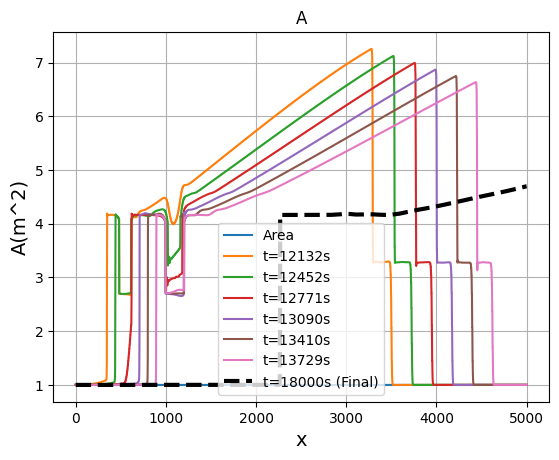

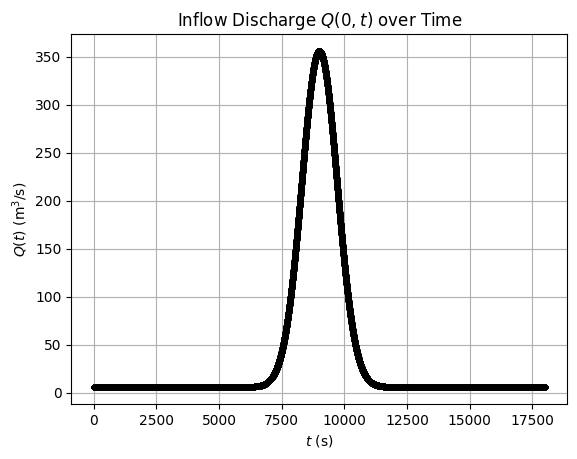

*************** PROGRAM ENDS ******************


In [20]:
import firedrake as fd
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec
import os.path
from ufl import tanh as ufl_tanh
#import os ONNO 11-02-2023: no idea about opnumthreats warning?
os.environ["OMP_NUM_THREADS"] = "1"


#
# Width functions
#
def width(w0, w1, sa, sb, kk1, ss):
 return w0-0.5*w1*(tanh(kk1*(ss-sa))*tanh(kk1*(sb-ss)))
#
def width2ufl(w0, w1, w2, sa, sb, kk1, kk2, sc, sd, ss):
 return w0-0.25*w1*(1+ufl_tanh(kk1*(ss-sa)))*(1+ufl_tanh(kk1*(sb-ss)))-0.25*w2*(1+ufl_tanh(kk2*(ss-sc)))*(1+ufl_tanh(kk2*(sd-ss)))
 # return w0-0.5*w1*(ufl_tanh(kk1*(ss-sa))*ufl_tanh(kk1*(sb-ss)))-0.5*w2*(ufl_tanh(kk2*(ss-sc))*ufl_tanh(kk2*(sd-ss)))

#
# Parameters
#
Nbc = 4
if Nbc==4:
    Tend = 3600*5 # UPDATE: set this one TC0: 5*3600; TC1: 5*3600
    CFL = 0.5*1.0
    Lx = 5000 # UPDATE: vary this one; 5000 may be a bit large; do a visual converge analysis
    grav = 9.81
    xo = 1000
    xa = 1500-xo
    xb = 1600-xo
    xc = 2000-xo
    xd = 2200-xo
    k1 = 0.024
    k2 = 0.027
    w0 = 100
    w1 = 90
    w2 = 80
    wb = 20
    hb = 4
    nRP = 1 # UPDATE 0: A=w0*h ;
    # 1: Test-Case-2: A<hb*wb A= h*wb ; A>hb*wb: A= A0+Ab=hb*wb+w0*(h-hb) so h-hb=(A-hb*wb)/w0;
    #                 R = A/(wb+2*hb+(w0-wb)+2*(h-hb)) = A/(wb+2*hb+(w0-wb)+2*(A-hb*wb)/w0)
    #                 A<hb*wb then P = wb+2*A/wb ; A>hb*wb then P=(wb+2*hb+(w0-wb)+2*(A-hb*wb)/w0)
    H0 = 1
    slope = -0.001
    sqrtmslope = np.sqrt(-slope)
    Cm = 0.1
    Nx = 2500
    dxx = Lx/Nx
    c00 = np.sqrt(grav*H0)
    dt = CFL*dxx/np.amax(c00) # This should be CFL*dxx/lambdamax
    nmea = 16
    tmease = 0.0
    dtmeas = Tend/nmea
    Qmax = 350  # UPDATE TC0, TC2-pretest) 0 constant influx; TC1/TC2) nonzero varying influx; on top of base flux
    tmax = 0.5*Tend
    gamfac = 0.000001
nnm = 0  # counter outputs

#
# Mesh
# mesh1d = UnitIntervalMesh(Nx)
mesh1d = fd.IntervalMesh(Nx,Lx)
# 2D mesh: mesh = ExtrudedMesh(mesh1d, layers=Ny) # not used
mesh = mesh1d
#  coords = mesh.coordinates
# 2D mesh and coordinates: coords.dat.data[:,0] = Lx*coords.dat.data[:,0] coords.dat.data = Lx*coords.dat.data # not used
x, = fd.SpatialCoordinate(mesh)
tsize=14
#
# Define function spaces
#
nDG = 0
nCG = 4
DG0 = fd.FunctionSpace(mesh, "DG", nDG) # Finite volume
CG1 = fd.FunctionSpace(mesh, "CG", nCG) # Continuous for width function wid0=w0(s)
A0 = fd.Function(DG0, name="A0") # Previous time step A^n
A01 = fd.Function(DG0, name="A01")
A02 = fd.Function(DG0, name="A02")
FA00 = fd.Function(DG0, name="FA00")
h00 = fd.Function(DG0, name="h00")
wid0 = fd.Function(CG1, name="wid0")
A1 = fd.Function(DG0, name="A1") # Future time step A^n+1
wid1 = fd.Function(DG0, name="wid1")
A0_trial = fd.TrialFunction(DG0) # Trial/test function; for DG0 unity in cell and zero elsewhere
wid0_trial = fd.TrialFunction(DG0)
A0_test = fd.TestFunction(DG0) # Trial/test function; for DG0 unity in cell and zero elsewhere
wid0_test = fd.TestFunction(DG0)

#
# We define n to be the built-in FacetNormal object;
# a unit normal vector that can be used in integrals over exterior and interior facets.
# We next define un to be an object which is equal to
# if this is positive, and zero if this is negative. This will be useful in the upwind terms.
# how to distinguish interior from exterior facets?
#

# initial condtion and plot it
tijd = 0.0
Ab = fd.Constant(wb*hb) # OB14112025
wbb = fd.Constant(wb)
hbb = fd.Constant(hb)
if Nbc==4: # flow
 wx = width2ufl(w0, w1, w2, xa, xb, k1, k2, xc, xd, x)
 if nRP==0:
  A0 = fd.Function(DG0).interpolate(H0*wx+0.0*x)
 elif nRP==1:
   A0 = fd.Function(DG0).interpolate(H0*wbb+0.0*x)
 wid0 = fd.Function(CG1).interpolate(wx+0.0*x)

t = tijd
t_ = fd.Constant(t)
smallfac = 10.0**(-10.0)

nx = 2*Nx
xsmall = 0.0*10**(-6)
xvals = np.linspace(0.0+xsmall, Lx-xsmall, nx)
widvals = 0.0*xvals


# --- Setup figures (REVISED) ---
# Figure 1: Water Depth h(s,t)
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(111)
ax1.set_title(r'Water Depth $h(s,t)$ Evolution',fontsize=tsize)
ax1.set_ylabel(r'$h(s,t)$ (m)',fontsize=tsize)
ax1.grid()

# Figure 2: Channel Width w(s)
fig2 = plt.figure(2)
ax2 = fig2.add_subplot(111)
ax2.set_title(r'Channel Width $w(s)$',fontsize=tsize)
ax2.set_ylabel(r'$w(s)$ (m)',fontsize=tsize)
ax2.grid()
ax2.set_xlabel(r'$s$ (m)',fontsize=tsize) # Added x-label here

# Figure 3: Discharge Q(s,t)
fig3 = plt.figure(3)
ax3 = fig3.add_subplot(111)
ax3.set_title(r'Discharge $Q(s,t)$ Evolution',fontsize=tsize)
ax3.set_xlabel(r'$s$ (m) ',fontsize=tsize)
ax3.set_ylabel(r'$Q(s,t)$ (m$^3$/s) ',fontsize=tsize)
ax3.grid()
#

fig5=plt.figure(4)
ax5=fig5.add_subplot(111)
ax5.set_title('A')
ax5.set_xlabel('x',fontsize=tsize)
ax5.set_ylabel('A(m^2)',fontsize=tsize)
ax5.grid()

#
widL = width2ufl(w0, w1, w2, xa, xb, k1, k2, xc, xd, x)
if nRP==0:
 phi12 = np.array([wid0.at(x) for x in xvals])
 FA00 = fd.Function(DG0).interpolate( sqrtmslope*A0**(5/3)/(widL+2.0*A0/widL)**(2/3)/Cm ) # TC0/TC1
 h00 = fd.Function(DG0).interpolate( A0/widL )
elif nRP==1:
 phi12 = np.array([wid0.at(x) for x in xvals])
 h00 = fd.Function(DG0).interpolate( fd.conditional( A0<Ab, A0/wbb, hbb+(A0-Ab)/widL) )
 FA00 = fd.Function(DG0).interpolate( fd.conditional( A0<Ab,sqrtmslope*A0**(5/3)/(wbb+2.0*A0/wbb)**(2/3)/Cm,sqrtmslope*A0**(5/3)/(wbb+2*hbb+widL-wbb+2.0*(A0-Ab)/widL)**(2/3)/Cm ) ) # TC2
Q12 = np.array([FA00.at(x) for x in xvals]) #
eta12 = np.array([h00.at(x) for x in xvals]) #
ax1.plot(xvals,eta12/phi12, label=f't=0s') # h = A/w
ax2.plot(xvals,phi12, '-k', label=r'Channel Width $w(s)$') # w
ax3.plot(xvals,Q12, label=f't=0s') # Q
ax5.plot(xvals,eta12, label=f'Area')

fig1.savefig("sweDG0FV_Depth_t0.png")
fig2.savefig("sweDG0FV_Width.png")
fig3.savefig("sweDG0FV_Discharge_t0.png")
#fig.savefig('sweDG0FV.png')
#
#
#
A00left = fd.Constant(H0*w0)
a_massA0 = A0_test*A0_trial*fd.dx # mass matrix for A0 widL = width2ufl(w0, w1, w2, xa, xb, k1, k2, xc, xd, x)
A0avg = 0.5*(A0('+') + A0('-'))
n = fd.FacetNormal(mesh) # outward normals
#
widL0 = width2ufl(w0, w1, w2, xa, xb, k1, k2, xc, xd, 0.0)
if nRP==0:
 #
 A0left = fd.Constant(H0*widL0) # constant inflow for test case
 A0left0 = H0*widL0
 #
elif nRP==1:
 #
 A0left = fd.Constant(H0*wb) # constant inflow for test case UPDATE to conditional works only if H0<hb; now cannot work when Q0 large but fixed below in time loop
 A0left0 = H0*wb
 #
FA0left = fd.Constant(0.0)

if nRP==0:
 #
 FA0 = sqrtmslope*A0**(5/3)/(widL+2.0*A0/widL)**(2/3)/Cm #
 FA0left.assign( sqrtmslope*A0left0**(5/3)/(widL0+2.0*A0left0/widL0)**(2/3)/Cm ) #
 FA0left0 = sqrtmslope*A0left0**(5/3)/(widL0+2.0*A0left0/widL0)**(2/3)/Cm
 FA0fluxmin = sqrtmslope*A0('-')**(5/3)/(widL+2.0*A0('-')/widL)**(2/3)/Cm #
 FA0fluxplu = sqrtmslope*A0('+')**(5/3)/(widL+2.0*A0('+')/widL)**(2/3)/Cm #
 dFA0dA0 = (1/3)*sqrtmslope*A0avg**(2/3)*( 5*widL+6*A0avg/widL )/(widL+2.0*A0avg/widL)**(5/3)/Cm #
 dFA0dA0bnd = (1/3)*sqrtmslope*A0**(2/3)*( 5*widL+6*A0/widL )/(widL+2.0*A0/widL)**(5/3)/Cm
 #
elif nRP==1:
 #
 FA0 = fd.conditional( A0<Ab, sqrtmslope*A0**(5/3)/(wbb+2.0*A0/wbb)**(2/3)/Cm,sqrtmslope*A0**(5/3)/(wbb+2*hbb+widL-wbb+2.0*(A0-Ab)/widL)**(2/3)/Cm )
 if A0left0<hb*wb:
  FA0left0 = sqrtmslope*A0left0**(5/3)/(wb+2.0*A0left0/wb)**(2/3)/Cm # FA0left0 does not need fd.Constant
 else:
  FA0left0 = sqrtmslope*A0left0**(5/3)/(wb+2*hb+widL0-wb+2.0*(A0left0-hb*wb)/widL0)**(2/3)/Cm # FA0left0 does not need fd.Constant
 FA0left.assign( FA0left0 )
 print('A0left0,FA0left0',A0left0,FA0left0)
 Peromi = fd.conditional( A0('-')<Ab, wbb+2*A0('-')/wbb, wbb+2*hbb+widL-wbb+2*(A0('-')-Ab)/widL )
 Peripl = fd.conditional( A0('+')<Ab, wbb+2*A0('+')/wbb, wbb+2*hbb+widL-wbb+2*(A0('+')-Ab)/widL )
 FA0fluxmin = sqrtmslope*A0('-')**(5/3)/Peromi**(2/3)/Cm #
 FA0fluxplu = sqrtmslope*A0('+')**(5/3)/Peripl**(2/3)/Cm #
 dFA0dA0 = (sqrtmslope/(3*Cm))*A0avg**(2/3)*fd.conditional(A0avg<Ab, (5*wbb+6*A0avg/wbb)/(wbb+2.0*A0avg/wbb)**(5/3),\
                                                           (5*(wbb+2*hbb+widL-wbb-2*Ab/widL)+6*A0avg/widL)/(wbb+2*hbb+widL-wbb+2*(A0avg-Ab)/widL)**(5/3) ) #
 dFA0dA0bnd = (sqrtmslope/(3*Cm))*A0**(2/3)*fd.conditional(A0<Ab, (5*wbb+6*A0/wbb)/(wbb+2.0*A0/wbb)**(5/3) , \
                                                             (5*(wbb+2*hbb+widL-wbb-2*Ab/widL)+6*A0/widL)/(wbb+2*hbb+widL-wbb+2*(A0-Ab)/widL)**(5/3) ) #
 #
# Upwind flux
FA0flux = fd.conditional(dFA0dA0*n[0]('+')>0,FA0fluxplu,FA0fluxmin) # 2D FA0flux = fd.conditional(fd.dot(dFA0dA0,n)>0,FA0fluxplu,FA0fluxmin)
FA0fluxbcl =  fd.conditional((dFA0dA0bnd*n[0])>0,FA0left,FA0left)#
FA0fluxbcr =  fd.conditional((dFA0dA0bnd*n[0])>0,FA0,FA0)
# RHS rewritten version with test function of: A^n - dt*(F_k+1/12-F_k-1/2))
A0rhs = A0_test*A0*fd.dx - dt*FA0flux*n[0]('+')*(A0_test('+')-A0_test('-'))*fd.dS # derivative of test function zero for DG0
# Boundary terms if cell near boundary ds(1) or ds(2)
A0rhs = A0rhs - dt*FA0fluxbcl*n[0]*A0_test*fd.ds(1) - dt*FA0fluxbcr*n[0]*A0_test*fd.ds(2) #
A0_problem = fd.LinearVariationalProblem(a_massA0, A0rhs, A1)
#
# Next 4 lines not used
#
A0rhs2 = fd.replace(A0rhs, {A0: A01})
A0rhs3 = fd.replace(A0rhs, {A0: A02})
A01_problem = fd.LinearVariationalProblem(a_massA0, A0rhs2, A1)
A02_problem = fd.LinearVariationalProblem(a_massA0, A0rhs3, A1)

#
params= {"ksp_type": "preonly", "pc_type": "jacobi"}
solv1 = fd.LinearVariationalSolver(A0_problem) # , solver_parameters) # =params)
solv11 = fd.LinearVariationalSolver(A01_problem) # , solver_parameters) # =params)
solv12 = fd.LinearVariationalSolver(A02_problem) # , solver_parameters) # =params)

dt0 = dt
dt = 0.0
#t_.assign(t)
#solv1.solve()
dt = dt0

print('Prior to start time loop. Hallo!')
nt = 0
tic = time.time()
Qs=[]
As=[]
stored_times=[]
while t <= Tend: #while nt<10:
    t += dt
    nt = nt+1

    t_.assign(t)
    # Variable time step:
    # dFdmax = fd.maximum( (1/3)*sqrtmslope*A0**(2/3)*( 5*widL+6*A0avg/widL )/(widL+2.0*A0/widL)**(5/3)/Cm )
    # dt = CFL*dxx/dFmax
    #
    # Assign inflow: FA0left0 does not need fd.Constant
    Q00 = FA0left0 + Qmax*np.exp(-gamfac*(t-tmax)**2)
    # print('FA0left0',FA0left0)
    FA0left.assign(Q00) #

    solv1.solve()
    A0.assign(A1)
    #
    #
    #
    #
    #
    #
    if t > 12000 and t < 14000 and nt % 1000 == 0:#t>tmease+smallfac: # if nt>0:
        # print('t, tmeas:',t, tmease)
        print('time counter and time: ',nt, t)
        tmease = tmease + dtmeas
        nnm = nnm+1
        stored_times.append(t)
        #  eta12 = np.array([A0.at(x) for x in xvals]) #
        phi12 = np.array([wid0.at(x) for x in xvals])
        if nRP==0:
          FA00 = fd.Function(DG0).interpolate( sqrtmslope*A0**(5/3)/(widL+2.0*A0/widL)**(2/3)/Cm ) #
          h00 = fd.Function(DG0).interpolate( A0/widL )
        elif nRP==1:
          FA00 = fd.Function(DG0).interpolate( fd.conditional(A0<Ab,sqrtmslope*A0**(5/3)/(wbb+2.0*A0/wbb)**(2/3)/Cm,sqrtmslope*A0**(5/3)/(wbb+2*hbb+widL-wbb+2.0*(A0-Ab)/widL)**(2/3)/Cm  ) )
          h00 = fd.Function(DG0).interpolate( fd.conditional( A0<Ab, A0/wbb, hbb+(A0-Ab)/widL) )
        eta12 = np.array([h00.at(x) for x in xvals]) #
        Q12 = np.array([FA00.at(x) for x in xvals])
        Qs.append(Q12)
        area= [A0.at(x) for x in xvals]
        As.append(area)

        #ax0.plot(xvals, eta12)
        # Plotting intermediate profiles
        ax1.plot(xvals,eta12/phi12, label=f't={t:.0f}s') # h = A/w
       # ax2.plot(xvals,phi12,'-k') # w is constant in time, only plotted once
        ax3.plot(xvals,Q12, label=f't={t:.0f}s') # Q
        ax5.plot(xvals,eta12, label=f't={t:.0f}s')

    #if t>tmE+smallfac:
    plt.figure(5) # New figure for Inflow Q(t)
    plt.plot(t,Q00,'.k')

# Plot Last profile
print('time counter and time: ',nt, t)
phi12 = np.array([wid0.at(x) for x in xvals])
if nRP==0:
 FA00 = fd.Function(DG0).interpolate( sqrtmslope*A0**(5/3)/(widL+2.0*A0/widL)**(2/3)/Cm ) #
 h00 = fd.Function(DG0).interpolate( A0/widL )
elif nRP==1:
 FA00 = fd.Function(DG0).interpolate( fd.conditional(A0<Ab,sqrtmslope*A0**(5/3)/(wbb+2.0*A0/wbb)**(2/3)/Cm,sqrtmslope*A0**(5/3)/(wbb+2*hbb+widL-wbb+2.0*(A0-Ab)/widL)**(2/3)/Cm  ) )
 h00 = fd.Function(DG0).interpolate( fd.conditional(A0<Ab,A0/wbb,hbb+(A0-Ab)/widL) )
#
eta12 = np.array([h00.at(x) for x in xvals]) #
Q12 = np.array([FA00.at(x) for x in xvals]) #
# Final profile plots
ax1.plot(xvals,eta12/phi12,'--k',linewidth=3, label=f't={t:.0f}s (Final)') # h
ax3.plot(xvals,Q12,'--k',linewidth=3, label=f't={t:.0f}s (Final)') # Q
ax5.plot(xvals,eta12,'--k',linewidth=3, label=f't={t:.0f}s (Final)')
# Note: w(s) (ax2) is time-independent and only needs one plot.

toc = time.time() - tic
print('Elapsed time (min):', toc/60)
# --- Save and show all figures (REVISED) ---
ax1.legend()
ax3.legend()
ax5.legend()

fig1.savefig("sweDG0FV_Depth_fin.png")
fig3.savefig("sweDG0FV_Discharge_fin.png")

plt.figure(5)
plt.title('Inflow Discharge $Q(0,t)$ over Time')
plt.xlabel('$t$ (s)')
plt.ylabel('$Q(t)$ (m$^3$/s)')
plt.grid()
plt.savefig("sweDG0FVEt.png")

plt.show()
print('*************** PROGRAM ENDS ******************')

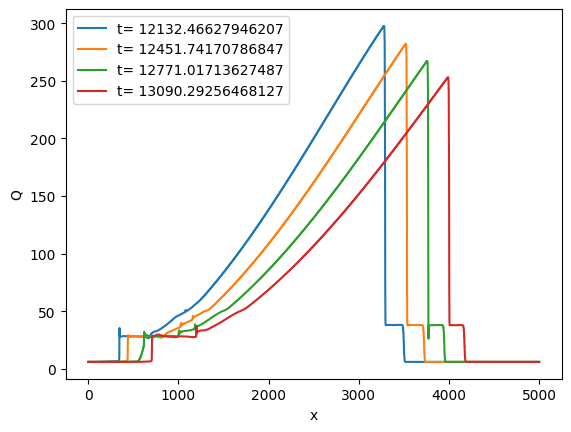

In [ ]:
indices = [0,1,2,3]

plt.figure()
for i in indices:
    plt.plot(xvals, Qs[i], label=f"t= {stored_times[i]}")

plt.xlabel("x")
plt.ylabel("Q")
plt.legend()
plt.show()

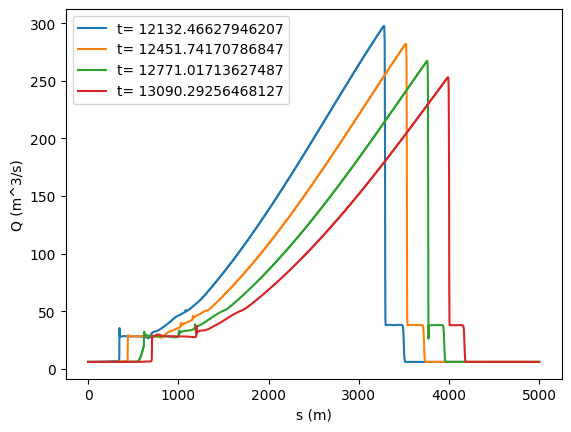

In [22]:
indices = [0,1,2,3]

plt.figure()
for i in indices:
    plt.plot(xvals, Qs[i], label=f"t= {stored_times[i]}")

plt.xlabel("s (m)")
plt.ylabel(r"Q (m^3/s)")
plt.legend()
plt.savefig("/content/drive/MyDrive/TC2Q.png",format="png",dpi=1000,bbox_inches="tight")
plt.show()

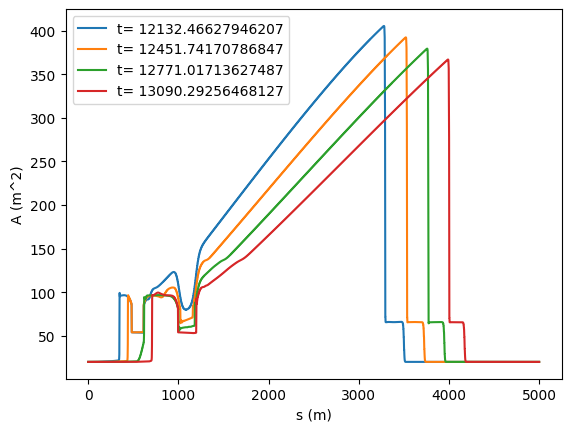

In [23]:
indices = [0,1,2,3]

plt.figure()
for i in indices:
    plt.plot(xvals, As[i], label=f"t= {stored_times[i]}")

plt.xlabel("s (m)")
plt.ylabel(r"A (m^2)")
plt.legend()
plt.savefig("/content/drive/MyDrive/TC2A.png",format="png",dpi=1000,bbox_inches="tight")
plt.show()

[np.float64(12132.46627946207), np.float64(12451.74170786847), np.float64(12771.01713627487), np.float64(13090.29256468127)]
[np.float64(0.7581178761236762), np.float64(0.739321565145403), np.float64(0.726790691159887)]


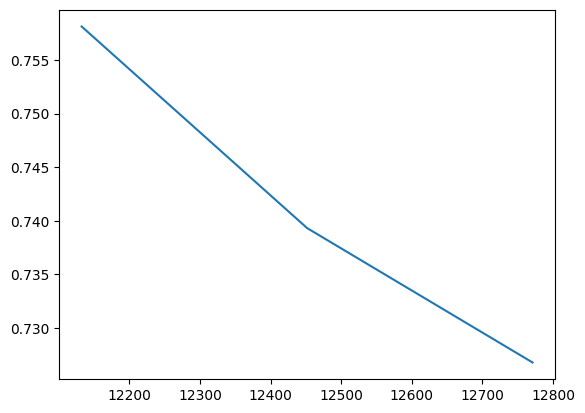

In [24]:
numerical_speeds=[]
ts=[]
for i in indices:
  ts.append(stored_times[i])
for i in range(len(indices)-1):
  smax= xvals[np.argmax(Qs[i])]
  spmax= xvals[np.argmax([Qs[i+1]])]
  ds = spmax-smax
  dt = stored_times[i+1]-stored_times[i]
  numerical_speeds.append(ds/dt)

print(ts)
plt.plot(ts[:-1],numerical_speeds)
print(numerical_speeds)

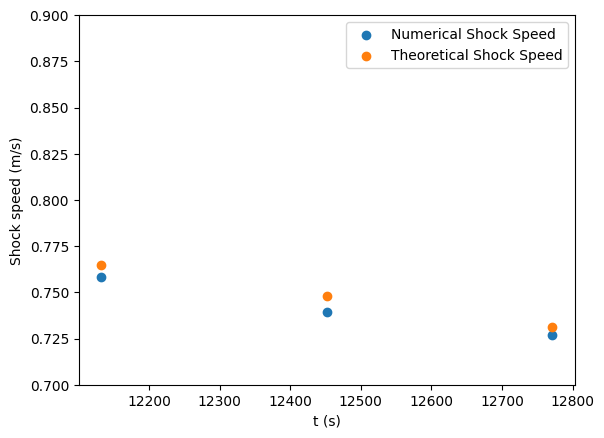

In [30]:
def Rankine_Stable_Finder(Profile, tolerance=1e-5, min_stable_cells=40):
    """
    Finds the upstream (High State) and downstream (Low State) stable values
    from a profile (Area or Flux) by tracking the max value and stabilization.

    Args:
        Profile (np.array): The Area or Flux profile at a given time (e.g., A6 or Q6).
        tolerance (float): Maximum change between adjacent cells for stability.
        min_stable_cells (int): Number of consecutive stable cells required.

    Returns:
        tuple: (Value_L, Value_R) or (np.nan, np.nan) if states are not found.
    """

    # 1. Find High State (Value_L)
    Value_L = np.max(Profile)
    maxindex = np.argmax(Profile)

    if maxindex >= len(Profile) - 2:
        print("Warning: Max value is near the end. Downstream tracking unreliable.")
        return Value_L, np.nan

    # 2. Track Stabilization Downstream (Find Value_R)
    stable_indices = []

    # Start scanning after the steep transition zone (maxindex + 1)
    search_start_index = maxindex + 1

    for i in range(search_start_index, len(Profile) - 1):

        delta_Profile = np.abs(Profile[i] - Profile[i+1])

        if delta_Profile < tolerance:
            # Add the current index to the stable list
            stable_indices.append(i)

            # Check if enough consecutive stable cells have been found
            if len(stable_indices) >= min_stable_cells:
                # Value_R is the average of the confirmed stable window
                Value_R = np.mean(Profile[i - min_stable_cells + 1 : i + 1])
                return Value_L, Value_R
        else:
            # If the change is significant, reset the counter
            stable_indices = []

    # If the loop finishes without finding a stable plateau
    return Value_L, np.nan

sigmas=[]
ALs=[]
Ars=[]
QLs=[]
QRs=[]
for i in range(len(indices)-1):
  AL, AR =  Rankine_Stable_Finder(As[i])
  QL, QR =  Rankine_Stable_Finder(Qs[i],tolerance=1e-3, min_stable_cells=4)
  ALs.append(AL)
  Ars.append(AR)
  QLs.append(QL)
  QRs.append(QR)
  sigma = (QL - 37.96296698035942) / (AL - 65.63625182175275)
  sigmas.append(sigma)


plt.scatter(ts[:-1],numerical_speeds,label="Numerical Shock Speed")
plt.ylim(0.7,0.9)
plt.scatter(ts[:-1],sigmas,label="Theoretical Shock Speed")
plt.xlabel("t (s)")
plt.legend()
plt.ylabel("Shock speed (m/s)")
plt.savefig("/content/drive/MyDrive/TC2sigma.png",format="png",dpi=1000,bbox_inches="tight")
plt.show()

QRs=[37.96296698035942,37.96296698035942,37.96296698035942]
Ars=[65.63625182175275,65.63625182175275,65.63625182175275]

In [ ]:
print(numerical_speeds)
print(sigmas)

[np.float64(0.7581178761236762), np.float64(0.739321565145403), np.float64(0.726790691159887)]
[np.float64(0.7647226946903511), np.float64(0.7480782723947521), np.float64(0.7312863852267342)]


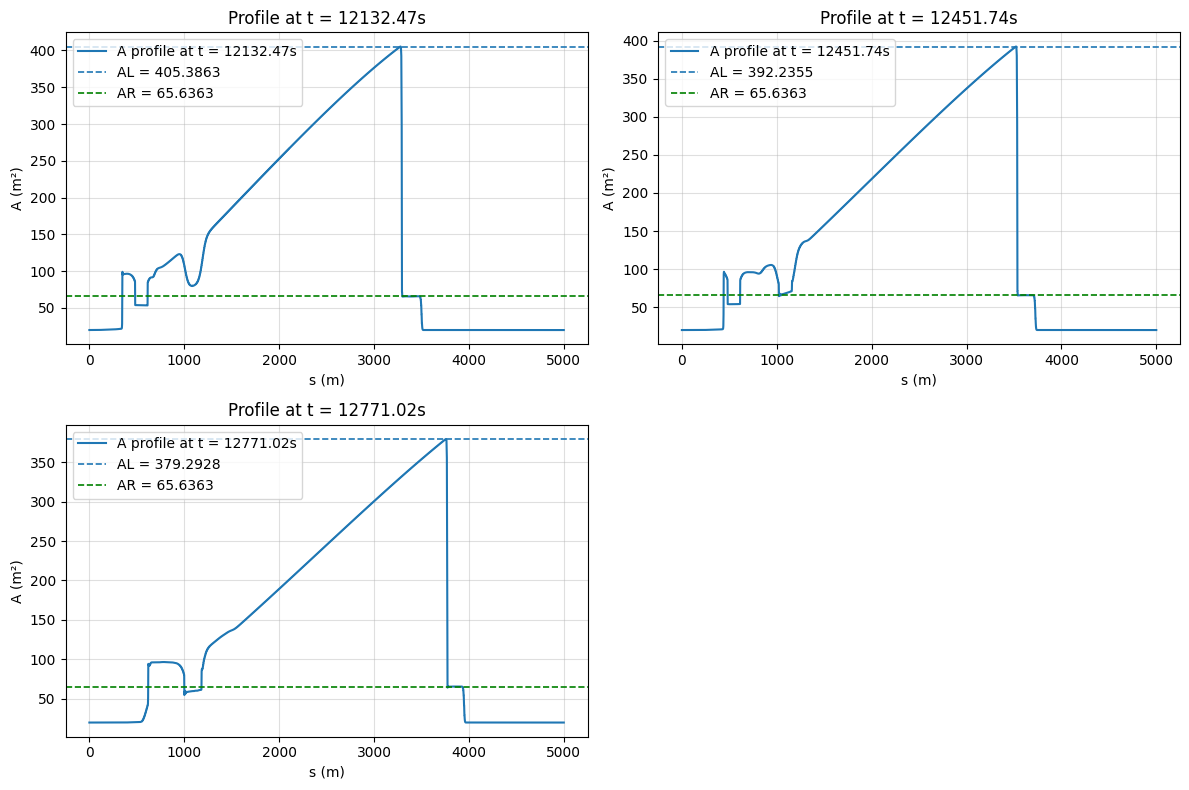

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i in range(3):   # three profiles
    ax = axes[i]

    # Plot Area profile
    ax.plot(xvals, As[i], label=f"A profile at t = {ts[i]:.2f}s")

    # AL line
    ax.axhline(ALs[i], linestyle='--', linewidth=1.2,
               label=f"AL = {ALs[i]:.4f}")

    # AR line
    ax.axhline(Ars[i], linestyle='--', linewidth=1.2,
               label=f"AR = {Ars[i]:.4f}",color="green")

    ax.set_title(f"Profile at t = {ts[i]:.2f}s")
    ax.set_xlabel("s (m)")
    ax.set_ylabel("A (m²)")
    ax.grid(True, alpha=0.4)
    ax.legend()

# Optional: leave the 4th subplot blank or label it
axes[3].axis("off")  # hide unused subplot
# axes[3].text(0.5, 0.5, "Extra panel", ha='center', va='center')

plt.tight_layout()
plt.show()

In [ ]:
for i in Qs[1]:
  print(i)

5.937600140436603
5.937600140436603
5.937671675086565
5.937671675086565
5.937745240362773
5.937745240362773
5.937820890933637
5.937820890933637
5.937898682849006
5.937898682849006
5.9379786735723705
5.9379786735723705
5.938060922013733
5.938060922013733
5.938145488563117
5.938145488563117
5.938232435124868
5.938232435124868
5.938321825152524
5.938321825152524
5.9384137236845085
5.9384137236845085
5.938508197380481
5.938508197380481
5.938605314558474
5.938605314558474
5.938705145232716
5.938705145232716
5.9388077611522805
5.9388077611522805
5.938913235840476
5.938913235840476
5.939021644634989
5.939021644634989
5.939133064728869
5.939133064728869
5.9392475752123195
5.9392475752123195
5.9393652571152415
5.9393652571152415
5.939486193450711
5.939486193450711
5.939610469259212
5.939610469259212
5.939738171653739
5.939738171653739
5.939869389865827
5.939869389865827
5.940004215292358
5.940004215292358
5.940142741543366
5.940142741543366
5.940285064490635
5.940285064490635
5.940431282317301


In [ ]:
for i in As[2]:
  print(i)

20.000504512936654
20.000504512936654
20.00052094415421
20.00052094415421
20.000537890392657
20.000537890392657
20.000555367118515
20.000555367118515
20.000573390240714
20.000573390240714
20.000591976122568
20.000591976122568
20.00061114159402
20.00061114159402
20.0006309039642
20.0006309039642
20.000651281034337
20.000651281034337
20.000672291110966
20.000672291110966
20.00069395301942
20.00069395301942
20.00071628611776
20.00071628611776
20.000739310310955
20.000739310310955
20.00076304606546
20.00076304606546
20.000787514424207
20.000787514424207
20.000812737021825
20.000812737021825
20.00083873610038
20.00083873610038
20.00086553452543
20.00086553452543
20.000893155802473
20.000893155802473
20.00092162409386
20.00092162409386
20.000950964236008
20.000950964236008
20.000981201757174
20.000981201757174
20.001012362895548
20.001012362895548
20.001044474617814
20.001044474617814
20.00107756463823
20.00107756463823
20.001111661438067
20.001111661438067
20.00114679428558
20.0011467942855

In [ ]:
for i in As[3]:
  print(i)

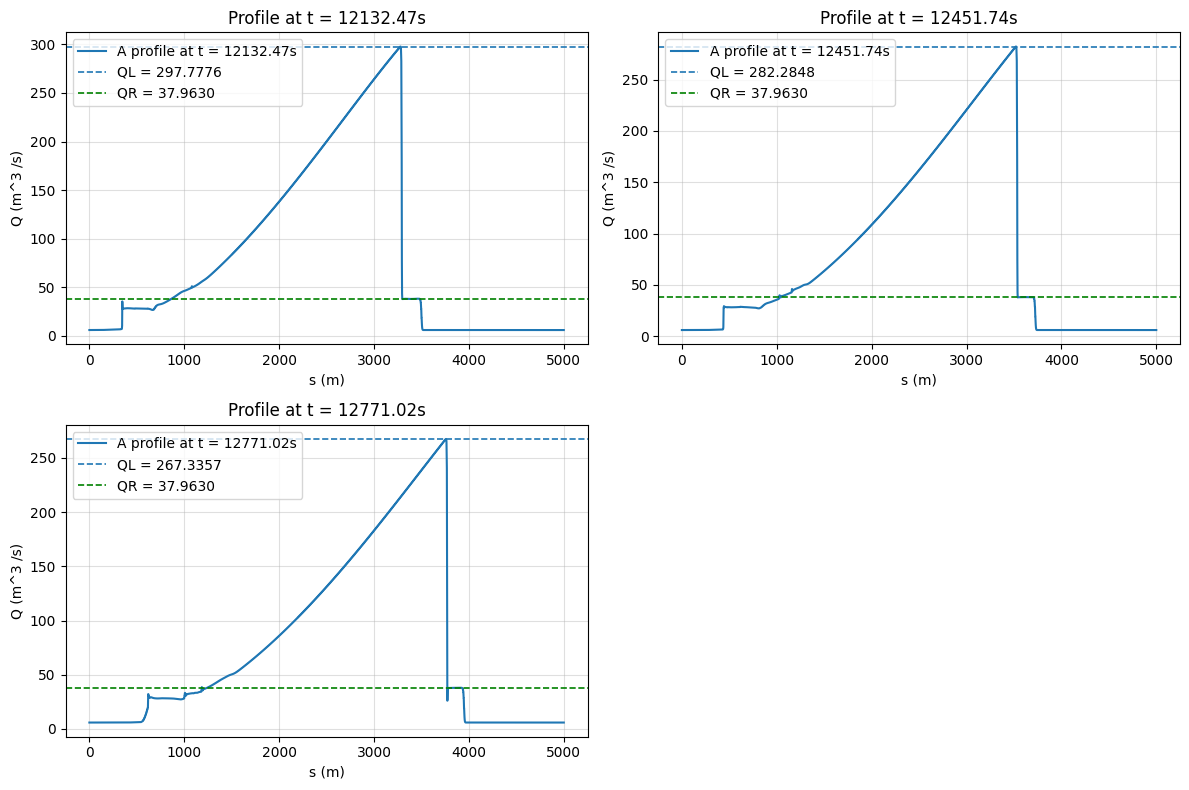

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i in range(3):   # three profiles
    ax = axes[i]

    # Plot Area profile
    ax.plot(xvals, Qs[i], label=f"A profile at t = {ts[i]:.2f}s")

    # AL line
    ax.axhline(QLs[i], linestyle='--', linewidth=1.2,
               label=f"QL = {QLs[i]:.4f}")

    # AR line
    ax.axhline(QRs[i], linestyle='--', linewidth=1.2,
               label=f"QR = {QRs[i]:.4f}",color="green")

    ax.set_title(f"Profile at t = {ts[i]:.2f}s")
    ax.set_xlabel("s (m)")
    ax.set_ylabel("Q (m^3 /s)")
    ax.grid(True, alpha=0.4)
    ax.legend()

# Optional: leave the 4th subplot blank or label it
axes[3].axis("off")  # hide unused subplot
# axes[3].text(0.5, 0.5, "Extra panel", ha='center', va='center')

plt.tight_layout()
plt.show()

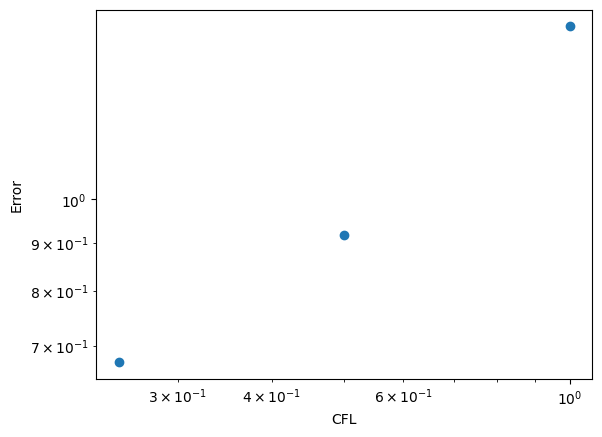

In [63]:
Q1 = np.load("/content/drive/MyDrive/Convergence_data/TC2/ANx2500CFL1.npz")
Q05 = np.load("/content/drive/MyDrive/Convergence_data/TC2/ANx2500CFL05.npz")
Q025 = np.load("/content/drive/MyDrive/Convergence_data/TC2/ANx2500CFL025.npz")
Q0125=np.load("/content/drive/MyDrive/Convergence_data/TC2/ANx2500CFL0125.npz")

Q1data = Q1["Q"]
Q05data = Q05["Q"]
Q025data = Q025["Q"]
Q0125data = Q0125["Q"]

et1= np.sqrt(np.mean((Q0125data - Q1data)**2))
et2= np.sqrt(np.mean((Q0125data - Q05data)**2))
et3= np.sqrt(np.mean((Q0125data - Q025data)**2))


errors=[et1,et2,et3]
cfl=[1,0.5,0.25]

plt.scatter(cfl,errors)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("CFL")
plt.ylabel("Error")
plt.savefig("/content/drive/MyDrive/TC2timeerror.png",format="png",dpi=1000,bbox_inches="tight")

plt.show()

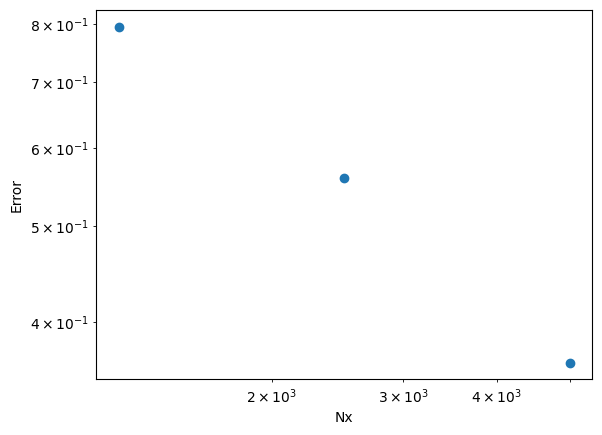

0.5651254243347076


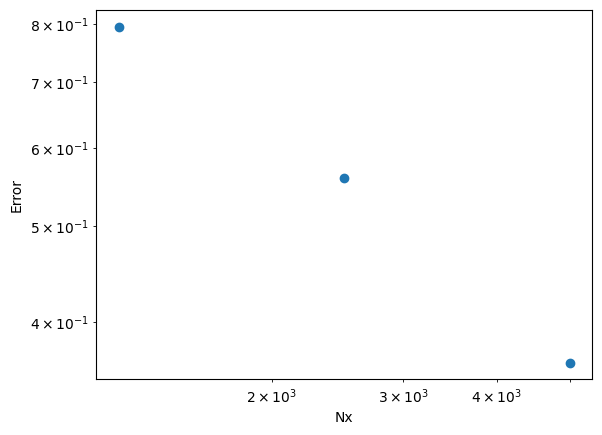

In [67]:
Q1250 = np.load("/content/drive/MyDrive/Convergence_data/TC2/ANx1250CFL05.npz")
Q2500 = np.load("/content/drive/MyDrive/Convergence_data/TC2/ANx2500CFL05.npz")
Q5000 = np.load("/content/drive/MyDrive/Convergence_data/TC2/ANx5000CFL05.npz")
Q10000=np.load("/content/drive/MyDrive/Convergence_data/TC2/ANx10000CFL05.npz")

Q1250data = Q1250["Q"]
Q2500data = Q2500["Q"]
Q5000data = Q5000["Q"]
Q10000data = Q10000["Q"]


highres=Q10000data[::stride(10000,5000)]
highres2= Q10000data[::stride(10000,2500)]
highres3= Q10000data[::stride(10000,1250)]

E1 = np.sqrt(np.mean((highres - Q5000data)**2))
E2 = np.sqrt(np.mean((highres2 - Q2500data)**2))
E3 = np.sqrt(np.mean((highres3 - Q1250data)**2))

errors=[E1,E2,E3]
resol=[5000,2500,1250]

plt.scatter(resol,errors)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Nx")
plt.ylabel("Error")
plt.savefig("/content/drive/MyDrive/TC2spatialerror.png",format="png",dpi=1000,bbox_inches="tight")
plt.show()

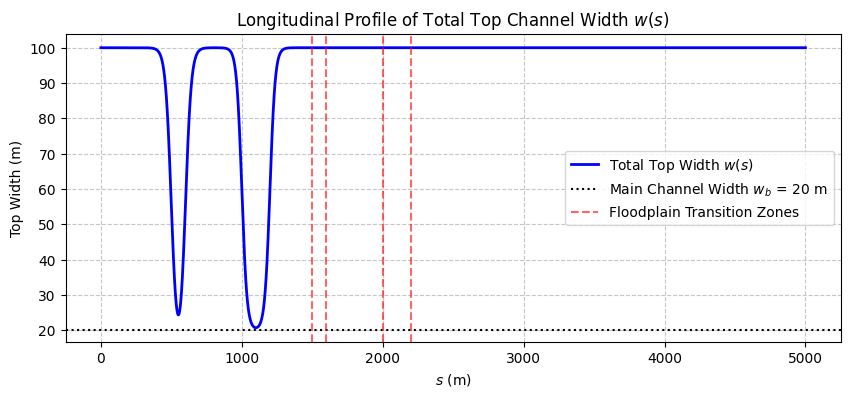

In [ ]:
def width2_np(scalar_s):
    """Numerical version of width2ufl for postprocessing."""
    ss = float(scalar_s)
    # Note: Using python's math.tanh since this is for numpy/plotting, not UFL
    t1 = np.tanh(k1*(ss - xa))
    t2 = np.tanh(k1*(xb - ss))
    t3 = np.tanh(k2*(ss - xc))
    t4 = np.tanh(k2*(xd - ss))
    # w_overall(s)
    return w0 - 0.25*w1*(1.0 + t1)*(1.0 + t2) - 0.25*w2*(1.0 + t3)*(1.0 + t4)

w_profile = np.array([width2_np(s) for s in xvals])

plt.figure(figsize=(10, 4))
plt.plot(xvals, w_profile, 'b-', linewidth=2, label='Total Top Width $w(s)$')
plt.axhline(wb, color='k', linestyle=':', label=f'Main Channel Width $w_b$ = {wb} m')

# Highlight the transition zones where the floodplain width changes
plt.axvline(xa+xo, color='r', linestyle='--', alpha=0.6)
plt.axvline(xb+xo, color='r', linestyle='--', alpha=0.6)
plt.axvline(xc+xo, color='r', linestyle='--', alpha=0.6)
plt.axvline(xd+xo, color='r', linestyle='--', alpha=0.6, label='Floodplain Transition Zones')

plt.title('Longitudinal Profile of Total Top Channel Width $w(s)$')
plt.xlabel('$s$ (m)')
plt.ylabel('Top Width (m)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.savefig('channel_geometry.png')
plt.show()

A0left0,FA0left0 20 5.935193360261284
Prior to start time loop. Hallo!
time counter and time:  1 0.3192754284070505
time counter and time:  3524 1125.1266097064868
time counter and time:  7048 2250.253219412898
time counter and time:  10571 3375.0605536902453


/usr/local/lib/python3.12/dist-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


time counter and time:  14095 4500.187163396575
time counter and time:  17619 5625.313773103931
time counter and time:  21142 6750.121107382881
time counter and time:  24666 7875.2477170902375
time counter and time:  28189 9000.055051366886
time counter and time:  31713 10125.181661071038
time counter and time:  35237 11250.30827077519
time counter and time:  38760 12375.115605050934
time counter and time:  42284 13500.242214755086
time counter and time:  45807 14625.049549030831
time counter and time:  49331 15750.176158734983
time counter and time:  52855 16875.302768439135
time counter and time:  56378 18000.11010271488
time counter and time:  56378 18000.11010271488
Elapsed time (min): 10.539650976657867


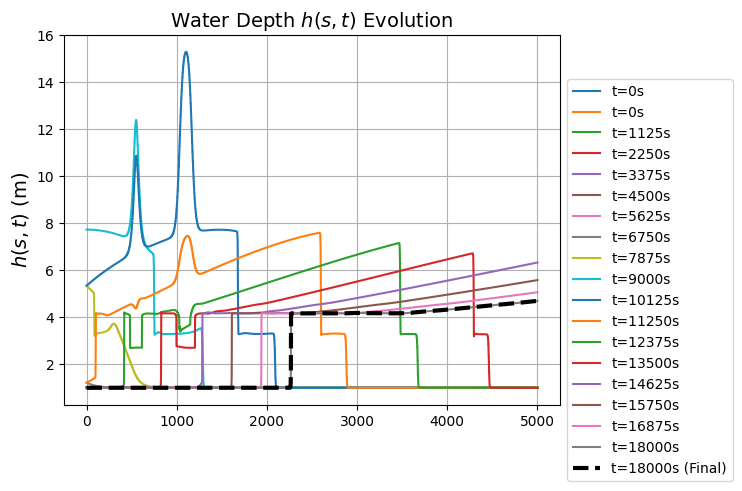

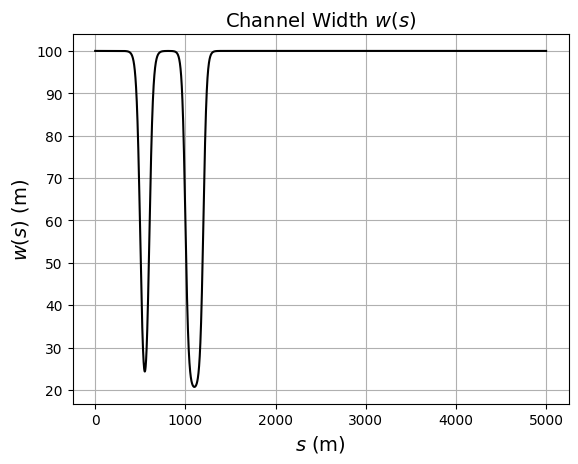

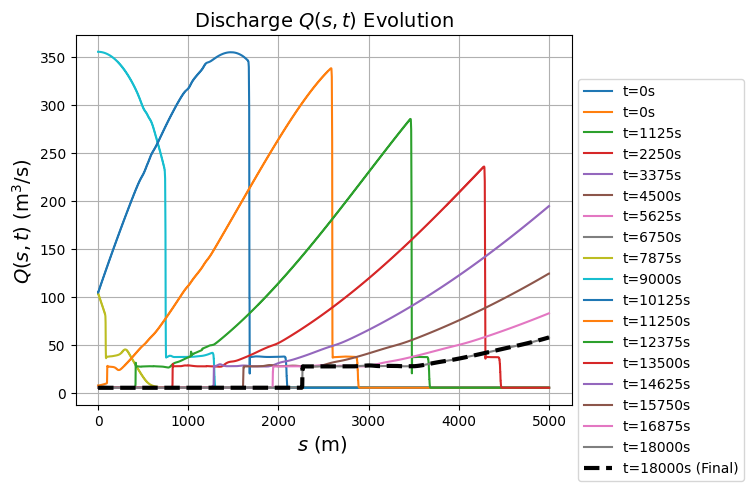

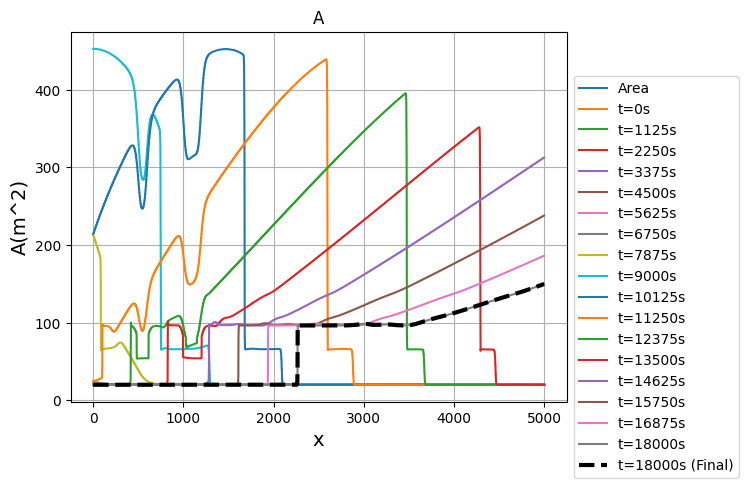

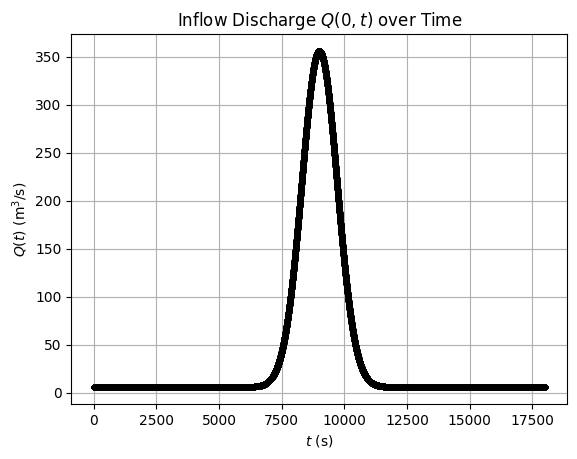

*************** PROGRAM ENDS ******************


In [103]:
import firedrake as fd
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec
import os.path
from ufl import tanh as ufl_tanh
#import os ONNO 11-02-2023: no idea about opnumthreats warning?
os.environ["OMP_NUM_THREADS"] = "1"


#
# Width functions
#
def width(w0, w1, sa, sb, kk1, ss):
 return w0-0.5*w1*(tanh(kk1*(ss-sa))*tanh(kk1*(sb-ss)))
#
def width2ufl(w0, w1, w2, sa, sb, kk1, kk2, sc, sd, ss):
 return w0-0.25*w1*(1+ufl_tanh(kk1*(ss-sa)))*(1+ufl_tanh(kk1*(sb-ss)))-0.25*w2*(1+ufl_tanh(kk2*(ss-sc)))*(1+ufl_tanh(kk2*(sd-ss)))
 # return w0-0.5*w1*(ufl_tanh(kk1*(ss-sa))*ufl_tanh(kk1*(sb-ss)))-0.5*w2*(ufl_tanh(kk2*(ss-sc))*ufl_tanh(kk2*(sd-ss)))

#
# Parameters
#
Nbc = 4
if Nbc==4:
    Tend = 3600*5 # UPDATE: set this one TC0: 5*3600; TC1: 5*3600
    CFL = 0.5*1.0
    Lx = 5000 # UPDATE: vary this one; 5000 may be a bit large; do a visual converge analysis
    grav = 9.81
    xo = 1000
    xa = 1500-xo
    xb = 1600-xo
    xc = 2000-xo
    xd = 2200-xo
    k1 = 0.024
    k2 = 0.027
    w0 = 100
    w1 = 90
    w2 = 80
    wb = 20
    hb = 4
    nRP = 1 # UPDATE 0: A=w0*h ;
    # 1: Test-Case-2: A<hb*wb A= h*wb ; A>hb*wb: A= A0+Ab=hb*wb+w0*(h-hb) so h-hb=(A-hb*wb)/w0;
    #                 R = A/(wb+2*hb+(w0-wb)+2*(h-hb)) = A/(wb+2*hb+(w0-wb)+2*(A-hb*wb)/w0)
    #                 A<hb*wb then P = wb+2*A/wb ; A>hb*wb then P=(wb+2*hb+(w0-wb)+2*(A-hb*wb)/w0)
    H0 = 1
    slope = -0.001
    sqrtmslope = np.sqrt(-slope)
    Cm = 0.1
    Nx = 2500
    dxx = Lx/Nx
    c00 = np.sqrt(grav*H0)
    dt = CFL*dxx/np.amax(c00) # This should be CFL*dxx/lambdamax
    nmea = 16
    tmease = 0.0
    dtmeas = Tend/nmea
    Qmax = 350  # UPDATE TC0, TC2-pretest) 0 constant influx; TC1/TC2) nonzero varying influx; on top of base flux
    tmax = 0.5*Tend
    gamfac = 0.000001
nnm = 0  # counter outputs

#
# Mesh
# mesh1d = UnitIntervalMesh(Nx)
mesh1d = fd.IntervalMesh(Nx,Lx)
# 2D mesh: mesh = ExtrudedMesh(mesh1d, layers=Ny) # not used
mesh = mesh1d
#  coords = mesh.coordinates
# 2D mesh and coordinates: coords.dat.data[:,0] = Lx*coords.dat.data[:,0] coords.dat.data = Lx*coords.dat.data # not used
x, = fd.SpatialCoordinate(mesh)
tsize=14
#
# Define function spaces
#
nDG = 0
nCG = 4
DG0 = fd.FunctionSpace(mesh, "DG", nDG) # Finite volume
CG1 = fd.FunctionSpace(mesh, "CG", nCG) # Continuous for width function wid0=w0(s)
A0 = fd.Function(DG0, name="A0") # Previous time step A^n
A01 = fd.Function(DG0, name="A01")
A02 = fd.Function(DG0, name="A02")
FA00 = fd.Function(DG0, name="FA00")
h00 = fd.Function(DG0, name="h00")
wid0 = fd.Function(CG1, name="wid0")
A1 = fd.Function(DG0, name="A1") # Future time step A^n+1
wid1 = fd.Function(DG0, name="wid1")
A0_trial = fd.TrialFunction(DG0) # Trial/test function; for DG0 unity in cell and zero elsewhere
wid0_trial = fd.TrialFunction(DG0)
A0_test = fd.TestFunction(DG0) # Trial/test function; for DG0 unity in cell and zero elsewhere
wid0_test = fd.TestFunction(DG0)

#
# We define n to be the built-in FacetNormal object;
# a unit normal vector that can be used in integrals over exterior and interior facets.
# We next define un to be an object which is equal to
# if this is positive, and zero if this is negative. This will be useful in the upwind terms.
# how to distinguish interior from exterior facets?
#

# initial condtion and plot it
tijd = 0.0
Ab = fd.Constant(wb*hb) # OB14112025
wbb = fd.Constant(wb)
hbb = fd.Constant(hb)
if Nbc==4: # flow
 wx = width2ufl(w0, w1, w2, xa, xb, k1, k2, xc, xd, x)
 if nRP==0:
  A0 = fd.Function(DG0).interpolate(H0*wx+0.0*x)
 elif nRP==1:
   A0 = fd.Function(DG0).interpolate(H0*wbb+0.0*x)
 wid0 = fd.Function(CG1).interpolate(wx+0.0*x)

t = tijd
t_ = fd.Constant(t)
smallfac = 10.0**(-10.0)

nx = 2*Nx
xsmall = 0.0*10**(-6)
xvals = np.linspace(0.0+xsmall, Lx-xsmall, nx)
widvals = 0.0*xvals


# --- Setup figures (REVISED) ---
# Figure 1: Water Depth h(s,t)
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(111)
ax1.set_title(r'Water Depth $h(s,t)$ Evolution',fontsize=tsize)
ax1.set_ylabel(r'$h(s,t)$ (m)',fontsize=tsize)
ax1.grid()

# Figure 2: Channel Width w(s)
fig2 = plt.figure(2)
ax2 = fig2.add_subplot(111)
ax2.set_title(r'Channel Width $w(s)$',fontsize=tsize)
ax2.set_ylabel(r'$w(s)$ (m)',fontsize=tsize)
ax2.grid()
ax2.set_xlabel(r'$s$ (m)',fontsize=tsize) # Added x-label here

# Figure 3: Discharge Q(s,t)
fig3 = plt.figure(3)
ax3 = fig3.add_subplot(111)
ax3.set_title(r'Discharge $Q(s,t)$ Evolution',fontsize=tsize)
ax3.set_xlabel(r'$s$ (m) ',fontsize=tsize)
ax3.set_ylabel(r'$Q(s,t)$ (m$^3$/s) ',fontsize=tsize)
ax3.grid()
#

fig5=plt.figure(4)
ax5=fig5.add_subplot(111)
ax5.set_title('A')
ax5.set_xlabel('x',fontsize=tsize)
ax5.set_ylabel('A(m^2)',fontsize=tsize)
ax5.grid()

#
widL = width2ufl(w0, w1, w2, xa, xb, k1, k2, xc, xd, x)
if nRP==0:
 phi12 = np.array([wid0.at(x) for x in xvals])
 FA00 = fd.Function(DG0).interpolate( sqrtmslope*A0**(5/3)/(widL+2.0*A0/widL)**(2/3)/Cm ) # TC0/TC1
 h00 = fd.Function(DG0).interpolate( A0/widL )
elif nRP==1:
 phi12 = np.array([wid0.at(x) for x in xvals])
 h00 = fd.Function(DG0).interpolate( fd.conditional( A0<Ab, A0/wbb, hbb+(A0-Ab)/widL) )
 FA00 = fd.Function(DG0).interpolate( fd.conditional( A0<Ab,sqrtmslope*A0**(5/3)/(wbb+2.0*A0/wbb)**(2/3)/Cm,sqrtmslope*A0**(5/3)/(wbb+2*hbb+widL-wbb+2.0*(A0-Ab)/widL)**(2/3)/Cm ) ) # TC2
Q12 = np.array([FA00.at(x) for x in xvals]) #
eta12 = np.array([h00.at(x) for x in xvals]) #
area= [A0.at(x) for x in xvals]

ax1.plot(xvals,eta12, label=f't=0s') # h = A/w
ax2.plot(xvals,phi12, '-k', label=r'Channel Width $w(s)$') # w
ax3.plot(xvals,Q12, label=f't=0s') # Q
ax5.plot(xvals,area, label=f'Area')

fig1.savefig("sweDG0FV_Depth_t0.png")
fig2.savefig("sweDG0FV_Width.png")
fig3.savefig("sweDG0FV_Discharge_t0.png")
#fig.savefig('sweDG0FV.png')
#
#
#
A00left = fd.Constant(H0*w0)
a_massA0 = A0_test*A0_trial*fd.dx # mass matrix for A0 widL = width2ufl(w0, w1, w2, xa, xb, k1, k2, xc, xd, x)
A0avg = 0.5*(A0('+') + A0('-'))
n = fd.FacetNormal(mesh) # outward normals
#
widL0 = width2ufl(w0, w1, w2, xa, xb, k1, k2, xc, xd, 0.0)
if nRP==0:
 #
 A0left = fd.Constant(H0*widL0) # constant inflow for test case
 A0left0 = H0*widL0
 #
elif nRP==1:
 #
 A0left = fd.Constant(H0*wb) # constant inflow for test case UPDATE to conditional works only if H0<hb; now cannot work when Q0 large but fixed below in time loop
 A0left0 = H0*wb
 #
FA0left = fd.Constant(0.0)

if nRP==0:
 #
 FA0 = sqrtmslope*A0**(5/3)/(widL+2.0*A0/widL)**(2/3)/Cm #
 FA0left.assign( sqrtmslope*A0left0**(5/3)/(widL0+2.0*A0left0/widL0)**(2/3)/Cm ) #
 FA0left0 = sqrtmslope*A0left0**(5/3)/(widL0+2.0*A0left0/widL0)**(2/3)/Cm
 FA0fluxmin = sqrtmslope*A0('-')**(5/3)/(widL+2.0*A0('-')/widL)**(2/3)/Cm #
 FA0fluxplu = sqrtmslope*A0('+')**(5/3)/(widL+2.0*A0('+')/widL)**(2/3)/Cm #
 dFA0dA0 = (1/3)*sqrtmslope*A0avg**(2/3)*( 5*widL+6*A0avg/widL )/(widL+2.0*A0avg/widL)**(5/3)/Cm #
 dFA0dA0bnd = (1/3)*sqrtmslope*A0**(2/3)*( 5*widL+6*A0/widL )/(widL+2.0*A0/widL)**(5/3)/Cm
 #
elif nRP==1:
 #
 FA0 = fd.conditional( A0<Ab, sqrtmslope*A0**(5/3)/(wbb+2.0*A0/wbb)**(2/3)/Cm,sqrtmslope*A0**(5/3)/(wbb+2*hbb+widL-wbb+2.0*(A0-Ab)/widL)**(2/3)/Cm )
 if A0left0<hb*wb:
  FA0left0 = sqrtmslope*A0left0**(5/3)/(wb+2.0*A0left0/wb)**(2/3)/Cm # FA0left0 does not need fd.Constant
 else:
  FA0left0 = sqrtmslope*A0left0**(5/3)/(wb+2*hb+widL0-wb+2.0*(A0left0-hb*wb)/widL0)**(2/3)/Cm # FA0left0 does not need fd.Constant
 FA0left.assign( FA0left0 )
 print('A0left0,FA0left0',A0left0,FA0left0)
 Peromi = fd.conditional( A0('-')<Ab, wbb+2*A0('-')/wbb, wbb+2*hbb+widL-wbb+2*(A0('-')-Ab)/widL )
 Peripl = fd.conditional( A0('+')<Ab, wbb+2*A0('+')/wbb, wbb+2*hbb+widL-wbb+2*(A0('+')-Ab)/widL )
 FA0fluxmin = sqrtmslope*A0('-')**(5/3)/Peromi**(2/3)/Cm #
 FA0fluxplu = sqrtmslope*A0('+')**(5/3)/Peripl**(2/3)/Cm #
 dFA0dA0 = (sqrtmslope/(3*Cm))*A0avg**(2/3)*fd.conditional(A0avg<Ab, (5*wbb+6*A0avg/wbb)/(wbb+2.0*A0avg/wbb)**(5/3),\
                                                           (5*(wbb+2*hbb+widL-wbb-2*Ab/widL)+6*A0avg/widL)/(wbb+2*hbb+widL-wbb+2*(A0avg-Ab)/widL)**(5/3) ) #
 dFA0dA0bnd = (sqrtmslope/(3*Cm))*A0**(2/3)*fd.conditional(A0<Ab, (5*wbb+6*A0/wbb)/(wbb+2.0*A0/wbb)**(5/3) , \
                                                             (5*(wbb+2*hbb+widL-wbb-2*Ab/widL)+6*A0/widL)/(wbb+2*hbb+widL-wbb+2*(A0-Ab)/widL)**(5/3) ) #
 #
# Upwind flux
FA0flux = fd.conditional(dFA0dA0*n[0]('+')>0,FA0fluxplu,FA0fluxmin) # 2D FA0flux = fd.conditional(fd.dot(dFA0dA0,n)>0,FA0fluxplu,FA0fluxmin)
FA0fluxbcl =  fd.conditional((dFA0dA0bnd*n[0])>0,FA0left,FA0left)#
FA0fluxbcr =  fd.conditional((dFA0dA0bnd*n[0])>0,FA0,FA0)
# RHS rewritten version with test function of: A^n - dt*(F_k+1/12-F_k-1/2))
A0rhs = A0_test*A0*fd.dx - dt*FA0flux*n[0]('+')*(A0_test('+')-A0_test('-'))*fd.dS # derivative of test function zero for DG0
# Boundary terms if cell near boundary ds(1) or ds(2)
A0rhs = A0rhs - dt*FA0fluxbcl*n[0]*A0_test*fd.ds(1) - dt*FA0fluxbcr*n[0]*A0_test*fd.ds(2) #
A0_problem = fd.LinearVariationalProblem(a_massA0, A0rhs, A1)
#
# Next 4 lines not used
#
A0rhs2 = fd.replace(A0rhs, {A0: A01})
A0rhs3 = fd.replace(A0rhs, {A0: A02})
A01_problem = fd.LinearVariationalProblem(a_massA0, A0rhs2, A1)
A02_problem = fd.LinearVariationalProblem(a_massA0, A0rhs3, A1)

#
params= {"ksp_type": "preonly", "pc_type": "jacobi"}
solv1 = fd.LinearVariationalSolver(A0_problem) # , solver_parameters) # =params)
solv11 = fd.LinearVariationalSolver(A01_problem) # , solver_parameters) # =params)
solv12 = fd.LinearVariationalSolver(A02_problem) # , solver_parameters) # =params)

dt0 = dt
dt = 0.0
#t_.assign(t)
#solv1.solve()
dt = dt0

print('Prior to start time loop. Hallo!')
nt = 0
tic = time.time()
Qs=[]
As=[]
stored_times=[]
while t <= Tend: #while nt<10:
    t += dt
    nt = nt+1

    t_.assign(t)
    # Variable time step:
    # dFdmax = fd.maximum( (1/3)*sqrtmslope*A0**(2/3)*( 5*widL+6*A0avg/widL )/(widL+2.0*A0/widL)**(5/3)/Cm )
    # dt = CFL*dxx/dFmax
    #
    # Assign inflow: FA0left0 does not need fd.Constant
    Q00 = FA0left0 + Qmax*np.exp(-gamfac*(t-tmax)**2)
    # print('FA0left0',FA0left0)
    FA0left.assign(Q00) #

    solv1.solve()
    A0.assign(A1)
    #
    #
    #
    #
    #
    #
    if t>tmease+smallfac: # if nt>0:
        # print('t, tmeas:',t, tmease)
        print('time counter and time: ',nt, t)
        tmease = tmease + dtmeas
        nnm = nnm+1
        #stored_times.append(t)
        #  eta12 = np.array([A0.at(x) for x in xvals]) #
        phi12 = np.array([wid0.at(x) for x in xvals])
        if nRP==0:
          FA00 = fd.Function(DG0).interpolate( sqrtmslope*A0**(5/3)/(widL+2.0*A0/widL)**(2/3)/Cm ) #
          h00 = fd.Function(DG0).interpolate( A0/widL )
        elif nRP==1:
          FA00 = fd.Function(DG0).interpolate( fd.conditional(A0<Ab,sqrtmslope*A0**(5/3)/(wbb+2.0*A0/wbb)**(2/3)/Cm,sqrtmslope*A0**(5/3)/(wbb+2*hbb+widL-wbb+2.0*(A0-Ab)/widL)**(2/3)/Cm  ) )
          h00 = fd.Function(DG0).interpolate( fd.conditional( A0<Ab, A0/wbb, hbb+(A0-Ab)/widL) )
        eta12 = np.array([h00.at(x) for x in xvals]) #
        Q12 = np.array([FA00.at(x) for x in xvals])
        Qs.append(Q12)
        area= [A0.at(x) for x in xvals]
        #As.append(area)

        #ax0.plot(xvals, eta12)
        # Plotting intermediate profiles
        ax1.plot(xvals,eta12, label=f't={t:.0f}s') # h = A/w
       # ax2.plot(xvals,phi12,'-k') # w is constant in time, only plotted once
        ax3.plot(xvals,Q12, label=f't={t:.0f}s') # Q
        ax5.plot(xvals,area, label=f't={t:.0f}s')

    #if t>tmE+smallfac:
    plt.figure(5) # New figure for Inflow Q(t)
    plt.plot(t,Q00,'.k')

# Plot Last profile
print('time counter and time: ',nt, t)
phi12 = np.array([wid0.at(x) for x in xvals])
if nRP==0:
 FA00 = fd.Function(DG0).interpolate( sqrtmslope*A0**(5/3)/(widL+2.0*A0/widL)**(2/3)/Cm ) #
 h00 = fd.Function(DG0).interpolate( A0/widL )
elif nRP==1:
 FA00 = fd.Function(DG0).interpolate( fd.conditional(A0<Ab,sqrtmslope*A0**(5/3)/(wbb+2.0*A0/wbb)**(2/3)/Cm,sqrtmslope*A0**(5/3)/(wbb+2*hbb+widL-wbb+2.0*(A0-Ab)/widL)**(2/3)/Cm  ) )
 h00 = fd.Function(DG0).interpolate( fd.conditional(A0<Ab,A0/wbb,hbb+(A0-Ab)/widL) )
#
eta12 = np.array([h00.at(x) for x in xvals]) #
Q12 = np.array([FA00.at(x) for x in xvals]) #
area= [A0.at(x) for x in xvals]
# Final profile plots
ax1.plot(xvals,eta12,'--k',linewidth=3, label=f't={t:.0f}s (Final)') # h
ax3.plot(xvals,Q12,'--k',linewidth=3, label=f't={t:.0f}s (Final)') # Q
ax5.plot(xvals,area,'--k',linewidth=3, label=f't={t:.0f}s (Final)')
# Note: w(s) (ax2) is time-independent and only needs one plot.

toc = time.time() - tic
print('Elapsed time (min):', toc/60)
# --- Save and show all figures (REVISED) ---
ax1.legend(bbox_to_anchor=(1, 0.9),fontsize=10)
ax3.legend(bbox_to_anchor=(1, 0.9),fontsize=10)
ax5.legend(bbox_to_anchor=(1, 0.9),fontsize=10)

fig1.savefig("TC21sweDG0FV_Depth_fin.png",format="png",dpi=1000,bbox_inches="tight")
fig3.savefig("TC21sweDG0FV_Discharge_fin.png",dpi=1000,format="png",bbox_inches="tight")
fig5.savefig("TC21sweDG0FV_Area_fin.png",format="png",dpi=1000,bbox_inches="tight")

plt.figure(5)
plt.title('Inflow Discharge $Q(0,t)$ over Time')
plt.xlabel('$t$ (s)')
plt.ylabel('$Q(t)$ (m$^3$/s)')
plt.grid()
plt.savefig("sweDG0FVEt.png")

plt.show()
print('*************** PROGRAM ENDS ******************')

In [17]:
data_dict={"x":xvals,
           "Q":Qs[-1]
}
np.savez("/content/drive/MyDrive/Convergence_data/TC2/QNx1250CFL05", **data_dict)
np.savez("/content/drive/MyDrive/Convergence_data/TC2/ANx1250CFL05", **data_dict)

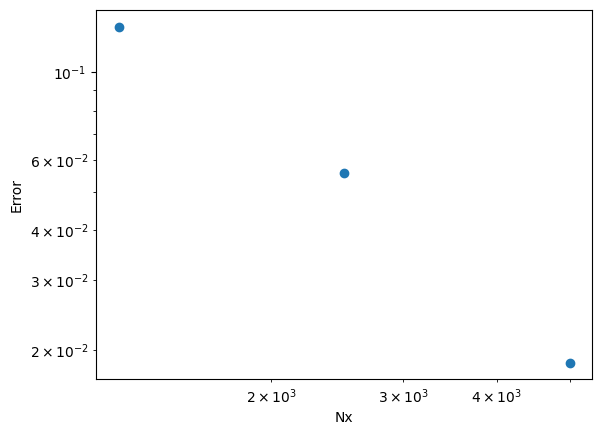

In [89]:
A1250 = np.load("/content/drive/MyDrive/Convergence_data/TC0/ANx1250CFL05.npz")
A2500 = np.load("/content/drive/MyDrive/Convergence_data/TC0/ANx2500CFL03.npz")
A5000 = np.load("/content/drive/MyDrive/Convergence_data/TC0/ANx5000CFL05.npz")
A10000 = np.load("/content/drive/MyDrive/Convergence_data/TC0/ANx10000CFL05.npz")

A1250data = A1250["Q"]
A2500data = A2500["Q"]
A5000data = A5000["Q"]
A10000data = A10000["Q"]
highres=A10000data[::stride(10000,5000)]
highres2= A10000data[::stride(10000,2500)]
highres3=A10000data[::stride(10000,1250)]


E1 = np.sqrt(np.mean((highres - A5000data)**2))
E2 = np.sqrt(np.mean((highres2 - A2500data)**2))
E3 = np.sqrt(np.mean((highres3 - A1250data)**2))

errs=[E1,E2,E3]
grids=[5000,2500,1250]
plt.scatter(grids,errs)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Nx")
plt.ylabel("Error")
plt.savefig("/content/drive/MyDrive/TC0spatialerror.png",format="png",dpi=1000,bbox_inches="tight")

plt.show()

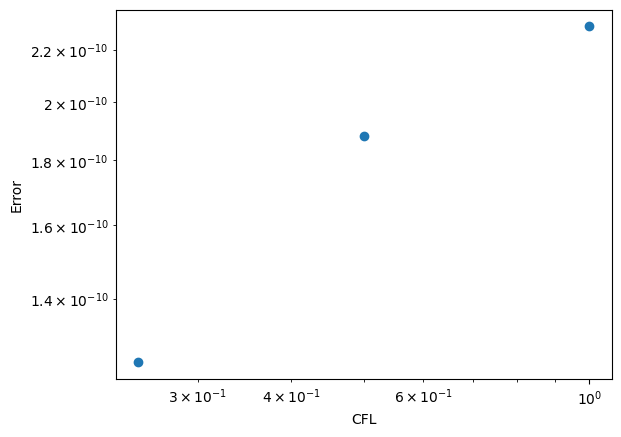

In [88]:
A1250t = np.load("/content/drive/MyDrive/Convergence_data/TC0/ANx2500CFL1.npz")
A2500t = np.load("/content/drive/MyDrive/Convergence_data/TC0/ANx2500CFL05.npz")
A5000t = np.load("/content/drive/MyDrive/Convergence_data/TC0/ANx2500CFL025.npz")
A10000t = np.load("/content/drive/MyDrive/Convergence_data/TC0/ANx2500CFL0125.npz")

A1250datat = A1250t["Q"]
A2500datat = A2500t["Q"]
A5000datat = A5000t["Q"]
A10000datat = A10000t["Q"]

err1=np.sqrt(np.mean((A10000datat - A1250datat)**2))
err2=np.sqrt(np.mean((A10000datat - A2500datat)**2))
err3=np.sqrt(np.mean((A10000datat - A5000datat)**2))

plt.scatter([1,0.5,0.25],[err1,err2,err3])
plt.yscale("log")
plt.xscale("log")
plt.xlabel("CFL")
plt.ylabel("Error")
plt.savefig("/content/drive/MyDrive/TC0timeerror.png",format="png",dpi=1000,bbox_inches="tight")
plt.show()

In [71]:
highres.shape

(2500,)